# Wildfire Spread Rate + Occurrence Prediction

In [1]:
import pandas as pd
import numpy as np
import requests
from pyproj import Transformer

df = pd.read_csv('../data/conus_ak/fired_conus_ak_2000_to_2024_events.csv')

transformer = Transformer.from_crs("epsg:32610", "epsg:4326", always_xy=True)  # Adjust EPSG if UTM zone varies
df['lon'], df['lat'] = transformer.transform(df['ig_utm_x'].values, df['ig_utm_y'].values)

df['ig_date'] = pd.to_datetime(df['ig_date'])
df['last_date'] = pd.to_datetime(df['last_date'])

def get_event_dates(row):
    return [row['ig_date'] + pd.Timedelta(days=i) for i in range(int(row['event_dur']))]

df['event_dates'] = df.apply(get_event_dates, axis=1)

df.head()

,id,geometry,ig_date,ig_day,ig_month,ig_year,last_date,event_dur,tot_pix,tot_ar_km2,...,lc_name,lc_desc,lc_type,eco_mode,eco_name,eco_type,tot_perim,lon,lat,event_dates
0,1,MULTIPOLYGON (((-10010798.656358264 4834667.34...,2007-02-01,32,2,2007,2007-02-01,1,1,0.214659,...,Evergreen Needleleaf Forests,Dominated by evergreen conifer trees (canopy>2...,IGBP global vegetation classification scheme,10.0,Central Pacific coastal forests,WWF Terrestrial Ecoregions of the World,1861.250866,163.280081,14.680764,[2007-02-01 00:00:00]
1,3,MULTIPOLYGON (((-10013578.656358264 4818451.34...,2003-10-31,304,10,2003,2003-11-04,5,5,1.073293,...,Evergreen Needleleaf Forests,Dominated by evergreen conifer trees (canopy>2...,IGBP global vegetation classification scheme,10.0,Central Pacific coastal forests,WWF Terrestrial Ecoregions of the World,7419.250866,163.312547,14.634074,"[2003-10-31 00:00:00, 2003-11-01 00:00:00, 200..."
2,4,MULTIPOLYGON (((-10026087.656358264 4817061.34...,2007-02-02,33,2,2007,2007-02-02,1,2,0.429317,...,Evergreen Needleleaf Forests,Dominated by evergreen conifer trees (canopy>2...,IGBP global vegetation classification scheme,10.0,Central Pacific coastal forests,WWF Terrestrial Ecoregions of the World,2787.250866,163.281524,14.602774,[2007-02-02 00:00:00]
3,5,MULTIPOLYGON (((-10025624.656358264 4816598.34...,2013-10-30,303,10,2013,2013-10-30,1,1,0.214659,...,Evergreen Needleleaf Forests,Dominated by evergreen conifer trees (canopy>2...,IGBP global vegetation classification scheme,10.0,Central Pacific coastal forests,WWF Terrestrial Ecoregions of the World,1861.250866,163.283768,14.602657,[2013-10-30 00:00:00]
4,6,MULTIPOLYGON (((-10024234.656358264 4816134.84...,2013-10-30,303,10,2013,2013-10-30,1,1,0.214659,...,Evergreen Needleleaf Forests,Dominated by evergreen conifer trees (canopy>2...,IGBP global vegetation classification scheme,10.0,Central Pacific coastal forests,WWF Terrestrial Ecoregions of the World,1861.250866,163.288380,14.604608,[2013-10-30 00:00:00]


In [2]:
df_filtered = df[df['ig_date'] > '2016-01-01'].copy()
len(df_filtered)

122481

In [3]:
import openmeteo_requests
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

OPEN_MATEO_API_KEY = "0VsL87d9nCTz6eRe"

weather_variables = [
    'weather_code',
    'temperature_2m_max',
    'temperature_2m_min',
    'apparent_temperature_max',
    'apparent_temperature_min',
    'precipitation_sum',
    'rain_sum',
    'snowfall_sum',
    'precipitation_hours',
    'sunshine_duration',
    'daylight_duration',
    'wind_speed_10m_max',
    'wind_gusts_10m_max',
    'wind_direction_10m_dominant',
    'shortwave_radiation_sum',
    'et0_fao_evapotranspiration'
]

def get_weather_history(lat, lon, ignition_date):
    """Get weather data for 14 days before ignition date using openmeteo_requests"""
    url = "https://customer-archive-api.open-meteo.com/v1/archive"

    # Convert ignition_date to datetime if it's a string
    if isinstance(ignition_date, str):
        ignition_date = pd.to_datetime(ignition_date)

    # Calculate the date 14 days before ignition
    preignition_date = (ignition_date - pd.Timedelta(days=14)).strftime('%Y-%m-%d')
    ignition_date_str = ignition_date.strftime('%Y-%m-%d')

    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": preignition_date,
        "end_date": ignition_date_str,
        "daily": weather_variables,
        "timezone": "auto",
        "apikey": OPEN_MATEO_API_KEY
    }

    try:
        responses = openmeteo.weather_api(url, params=params)
        # Process first location
        response = responses[0]

        # Process daily data
        daily = response.Daily()

        # Create a dictionary to hold the data
        weather_data = {
            "date": pd.date_range(
                start=pd.to_datetime(daily.Time(), unit="s"),
                end=pd.to_datetime(daily.TimeEnd(), unit="s"),
                freq=pd.Timedelta(days=1),
                inclusive="left"
            )
        }

        # Process each weather variable - the order matters and must match the request
        for idx, var in enumerate(weather_variables):
            if daily.Variables(idx) is not None:
                weather_data[var] = daily.Variables(idx).ValuesAsNumpy()

        # Create DataFrame
        weather_df = pd.DataFrame(data=weather_data)

        # Add metadata
        weather_df['lat'] = lat
        weather_df['lon'] = lon
        weather_df['ignition_date'] = ignition_date_str
        weather_df['days_before_ignition'] = (ignition_date - weather_df['date']).dt.days

        return weather_df
    except Exception as e:
        print(f"Exception occurred: {e}")
        return None

In [ ]:
import json
import numpy as np
import pandas as pd
import time
import os
from datetime import datetime
from tqdm import tqdm

# Create output directory if it doesn't exist
os.makedirs('../data/weather_data', exist_ok=True)

# Store fire event IDs with their weather data file paths
weather_metadata = []

# Process each fire event
with tqdm(total=len(df_filtered), desc="Processing fire events") as pbar:
    for idx, row in df_filtered.iterrows():
        fire_id = row['id']
        lat = row['lat']
        lon = row['lon']
        ig_date = row['ig_date']

        # Check if file already exists to avoid redundant API calls
        filename = f"../data/weather_data/fire_{fire_id}_{ig_date.strftime('%Y%m%d')}.csv"
        if os.path.exists(filename):
            weather_metadata.append({
                'fire_id': fire_id,
                'ignition_date': ig_date,
                'lat': lat,
                'lon': lon,
                'weather_file': filename
            })
            pbar.update(1)
            continue

        # Get weather data
        weather_df = get_weather_history(lat, lon, ig_date)

        if weather_df is not None:
            # Save to CSV
            weather_df.to_csv(filename, index=False)

            # Record metadata
            weather_metadata.append({
                'fire_id': fire_id,
                'ignition_date': ig_date,
                'lat': lat,
                'lon': lon,
                'weather_file': filename
            })

        # Update progress bar
        pbar.update(1)

        # The library handles rate limiting internally, but we can add a small
        # delay if needed for very large datasets
        if idx % 100 == 0 and idx > 0:
            time.sleep(1)

# Create a metadata file that links fire events to their weather data files
metadata_df = pd.DataFrame(weather_metadata)
metadata_df.to_csv('../data/weather_data/weather_metadata.csv', index=False)

print(f"Completed processing {len(df_filtered)} fire events.")
print(f"Successfully retrieved weather data for {len(weather_metadata)} events.")

# Helper function to load weather data
def load_fire_weather(fire_id=None, metadata_path='../data/weather_data/weather_metadata.csv'):
    """
    Load weather data for a specific fire or all fires

    Parameters:
    - fire_id: Optional ID of the fire to load data for
    - metadata_path: Path to the metadata CSV file

    Returns:
    - If fire_id is provided: DataFrame with weather history for that fire
    - If fire_id is None: Dictionary mapping fire IDs to their weather DataFrames
    """
    # Load metadata
    metadata = pd.read_csv(metadata_path)

    if fire_id is not None:
        # Get the specific fire's metadata
        fire_meta = metadata[metadata['fire_id'] == fire_id]

        if len(fire_meta) == 0:
            print(f"No weather data found for fire ID {fire_id}")
            return None

        # Load the CSV file
        weather_file = fire_meta.iloc[0]['weather_file']
        return pd.read_csv(weather_file, parse_dates=['date'])
    else:
        # Load all fire weather data
        weather_data = {}
        for _, row in metadata.iterrows():
            fire_id = row['fire_id']
            weather_file = row['weather_file']
            weather_data[fire_id] = pd.read_csv(weather_file, parse_dates=['date'])

        return weather_data

Processing fire events: 100%|██████████| 122481/122481 [00:06<00:00, 18374.07it/s]


Completed processing 122481 fire events.
Successfully retrieved weather data for 122481 events.


In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import pandas as pd
from datetime import timedelta

metadata_df = pd.read_csv('../data/weather_data/weather_metadata.csv')

# Extract unique locations from the existing metadata_df
unique_locations = metadata_df[['fire_id', 'lat', 'lon']].drop_duplicates()

# Initialize a list to store non-fire weather data
non_fire_weather_data = []

# Function to find a non-fire date
def find_non_fire_date(ignition_dates, min_gap_days=180):
    """Find a date that is at least min_gap_days away from any ignition date."""
    ignition_dates_dt = [pd.to_datetime(date) for date in ignition_dates]
    ignition_dates_set = set(ignition_dates_dt)
    start_date = min(ignition_dates_dt) - timedelta(days=365)
    current_date = start_date
    while current_date in ignition_dates_set or any(
        abs((current_date - date).days) < min_gap_days for date in ignition_dates_set
    ):
        current_date += timedelta(days=1)
    return current_date

# Function to fetch weather data for a given location
def fetch_weather_data(fire_id, lat, lon, ignition_dates):
    non_fire_date = find_non_fire_date(ignition_dates)
    weather_df_non_fire = get_weather_history(lat, lon, non_fire_date)
    if weather_df_non_fire is not None:
        weather_df_non_fire['fire_id'] = fire_id  # Associate with fire ID
    return weather_df_non_fire

# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor(max_workers=10) as executor:
    # Create a list of futures
    futures = []
    for _, row in unique_locations.iterrows():
        fire_id = row['fire_id']
        lat = row['lat']
        lon = row['lon']
        location_ignition_dates = metadata_df[
            (metadata_df['lat'] == lat) & (metadata_df['lon'] == lon)
        ]['ignition_date'].unique()
        futures.append(executor.submit(fetch_weather_data, fire_id, lat, lon, location_ignition_dates))

    # Use tqdm to show progress
    for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching non-fire weather data"):
        weather_df_non_fire = future.result()
        if weather_df_non_fire is not None:
            non_fire_weather_data.append(weather_df_non_fire)

# Concatenate all DataFrames into a single DataFrame
non_fire_weather_df = pd.concat(non_fire_weather_data, ignore_index=True)

print("Collected non-fire weather data for existing locations.")
non_fire_weather_df.head()

Fetching non-fire weather data: 100%|██████████| 122481/122481 [00:00<00:00, 145356.29it/s]


Collected non-fire weather data for existing locations.


,date,weather_code,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,...,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,lat,lon,ignition_date,days_before_ignition,fire_id
0,2021-06-23 13:00:00,1.0,24.950001,24.049999,32.297268,28.339367,0.0,0.0,0.0,0.0,...,11.966954,16.559999,151.896500,28.719999,5.277283,30.744521,164.530996,2021-07-08,14,291276.0
1,2021-06-24 13:00:00,1.0,25.650000,24.250000,31.247883,27.910309,0.0,0.0,0.0,0.0,...,14.565548,19.799999,107.827484,28.450001,5.072739,30.744521,164.530996,2021-07-08,13,291276.0
2,2021-06-25 13:00:00,51.0,25.950001,25.049999,30.646248,28.224453,0.3,0.3,0.0,3.0,...,16.548256,22.319998,133.858490,26.280001,4.754352,30.744521,164.530996,2021-07-08,12,291276.0
3,2021-06-26 13:00:00,2.0,25.650000,25.049999,29.951336,28.040390,0.0,0.0,0.0,0.0,...,13.104198,18.359999,168.925171,28.270000,5.184426,30.744521,164.530996,2021-07-08,11,291276.0
4,2021-06-27 13:00:00,3.0,26.549999,24.750000,30.549728,27.620302,0.0,0.0,0.0,0.0,...,16.923828,22.319998,170.668655,27.469999,5.389575,30.744521,164.530996,2021-07-08,10,291276.0


In [ ]:
# Ensure fire_id is an integer
non_fire_weather_df['fire_id'] = non_fire_weather_df['fire_id'].astype(int)
non_fire_weather_df['fire_id']

0          291276
1          291276
2          291276
3          291276
4          291276
            ...  
1837210    296241
1837211    296241
1837212    296241
1837213    296241
1837214    296241
Name: fire_id, Length: 1837215, dtype: int64

In [ ]:
def aggregate_non_fire_weather_metrics(non_fire_weather_df):
    """
    Aggregate statistical metrics from non-fire weather data for each location and date.
     """
    # List of weather variables to aggregate (excluding weather_code)
    weather_vars = [
        'temperature_2m_max',
        'temperature_2m_min',
        'apparent_temperature_max',
        'apparent_temperature_min',
        'precipitation_sum',
        'rain_sum',
        'snowfall_sum',
        'precipitation_hours',
        'sunshine_duration',
        'daylight_duration',
        'wind_speed_10m_max',
        'wind_gusts_10m_max',
        'wind_direction_10m_dominant',
        'shortwave_radiation_sum',
        'et0_fao_evapotranspiration'
    ]

    # Define aggregation functions
    agg_functions = {
        'mean': np.mean,
        'median': np.median,
        'min': np.min,
        'max': np.max,
        'std': np.std,
        'sum': np.sum,
        'range': lambda x: np.max(x) - np.min(x),
        'q25': lambda x: np.percentile(x, 25),
        'q75': lambda x: np.percentile(x, 75),
        'iqr': lambda x: np.percentile(x, 75) - np.percentile(x, 25),
        'last3_mean': lambda x: np.mean(x[-3:]) if len(x) >= 3 else np.nan,  # Mean of last 3 days
        'last7_mean': lambda x: np.mean(x[-7:]) if len(x) >= 7 else np.nan,  # Mean of last 7 days
    }

    # Variables to skip certain aggregations for (e.g., sum doesn't make sense for temperature)
    skip_sum = ['temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max',
                'apparent_temperature_min', 'wind_direction_10m_dominant']

    aggregated_data = []

    # Group by fire_id, lat, lon, and ignition_date
    grouped = non_fire_weather_df.groupby(['fire_id', 'lat', 'lon', 'ignition_date'])

    # Process each group
    for (fire_id, lat, lon, ignition_date), group in tqdm(grouped, desc="Aggregating non-fire metrics"):
        # Sort by days_before_ignition 
        group = group.sort_values('days_before_ignition', ascending=False)

        # Exclude the ignition day
        group = group[group['days_before_ignition'] > 0]

        # Create dictionary for this group's aggregated metrics
        metrics = {'fire_id': fire_id, 'lat': lat, 'lon': lon, 'ignition_date': ignition_date}

        # Calculate metrics for each variable
        for var in weather_vars:
            if var not in group.columns:
                continue

            # Skip rows with NaN values
            var_data = group[var].dropna()

            if len(var_data) == 0:
                continue

            # Apply each aggregation function
            for agg_name, agg_func in agg_functions.items():
                # Skip sum for variables where it doesn't make sense
                if agg_name == 'sum' and var in skip_sum:
                    continue

                try:
                    result = agg_func(var_data)
                    metrics[f"{var}_{agg_name}"] = result
                except Exception as e:
                    print(f"Error calculating {agg_name} for {var} at ({lat}, {lon}) on {ignition_date}: {e}")

        # Add trend metrics (changes over time)
        for var in weather_vars:
            if var in skip_sum:  # Skip directional variables for trend analysis
                continue

            if var not in group.columns:
                continue

            var_data = group[var].dropna()

            if len(var_data) < 7:
                continue

            # Calculate trend (slope) using last 14 days
            try:
                days = np.arange(len(var_data))
                if len(days) > 0 and len(var_data) > 0:
                    trend = np.polyfit(days, var_data, 1)[0]
                    metrics[f"{var}_trend"] = trend
            except Exception as e:
                print(f"Error calculating trend for {var} at ({lat}, {lon}) on {ignition_date}: {e}")

        # Calculate temporal metrics (specific days before ignition)
        days_of_interest = [1, 2, 3, 5, 7, 14]
        for day in days_of_interest:
            day_data = group[group['days_before_ignition'] == day]
            if len(day_data) == 0:
                continue

            for var in weather_vars:
                if var not in day_data.columns or pd.isna(day_data[var].iloc[0]):
                    continue

                metrics[f"{var}_day{day}"] = day_data[var].iloc[0]

        aggregated_data.append(metrics)

    if not aggregated_data:
        print("No valid aggregated data found!")
        return None

    aggregated_df = pd.DataFrame(aggregated_data)

    return aggregated_df

# Run the aggregation
aggregated_non_fire_metrics_df = aggregate_non_fire_weather_metrics(non_fire_weather_df)
aggregated_non_fire_metrics_df.to_csv('../data/aggregated_non_fire_weather_metrics.csv', index=False)

print(f"Saved aggregated non-fire metrics to ../data/aggregated_non_fire_weather_metrics.csv")
print("\nSample of aggregated non-fire metrics:")
aggregated_non_fire_metrics_df.head()

Aggregating non-fire metrics: 100%|██████████| 122481/122481 [16:20<00:00, 124.86it/s]


Saved aggregated non-fire metrics to ../data/aggregated_non_fire_weather_metrics.csv

Sample of aggregated non-fire metrics:


,fire_id,lat,lon,ignition_date,temperature_2m_max_mean,temperature_2m_max_median,temperature_2m_max_min,temperature_2m_max_max,temperature_2m_max_std,temperature_2m_max_range,...,rain_sum_day14,snowfall_sum_day14,precipitation_hours_day14,sunshine_duration_day14,daylight_duration_day14,wind_speed_10m_max_day14,wind_gusts_10m_max_day14,wind_direction_10m_dominant_day14,shortwave_radiation_sum_day14,et0_fao_evapotranspiration_day14
0,16,14.617790,163.329689,2017-10-22,28.621428,28.725,28.049999,29.150000,0.326625,1.100000,...,1.800000,0.0,5.0,40208.289062,42876.519531,25.071098,33.119999,67.049126,21.750000,5.046175
1,19,14.561815,163.289361,2017-10-20,28.614288,28.600,28.049999,29.200001,0.352759,1.150002,...,24.699999,0.0,17.0,3912.634521,42973.226562,41.125172,55.799999,83.882568,8.970000,3.078090
2,21,14.538290,163.279034,2022-09-16,28.696428,29.025,26.900000,29.900000,0.836546,3.000000,...,0.900000,0.0,5.0,42105.398438,44617.480469,33.994751,45.360001,88.401115,25.760000,5.990404
3,25,14.414217,163.174572,2019-09-06,28.771425,28.875,27.900000,29.200001,0.370191,1.300001,...,11.200001,0.0,15.0,37644.679688,45075.609375,25.045238,36.719997,112.523834,17.280001,3.586782
4,26,14.518580,163.299238,2017-10-20,28.607145,28.625,28.000000,29.150000,0.366867,1.150000,...,23.700001,0.0,17.0,5015.255371,42976.320312,40.796116,55.079998,84.948402,9.480000,3.100664


In [ ]:
metadata_df

,fire_id,ignition_date,lat,lon,weather_file
0,16,2018-10-22,14.617790,163.329689,../data/weather_data/fire_16_20181022.csv
1,19,2018-10-20,14.561815,163.289361,../data/weather_data/fire_19_20181020.csv
2,21,2023-09-16,14.538290,163.279034,../data/weather_data/fire_21_20230916.csv
3,25,2020-09-05,14.414217,163.174572,../data/weather_data/fire_25_20200905.csv
4,26,2018-10-20,14.518580,163.299238,../data/weather_data/fire_26_20181020.csv
...,...,...,...,...,...
122476,517086,2019-08-22,39.009169,164.844545,../data/weather_data/fire_517086_20190822.csv
122477,517087,2019-08-16,38.989999,164.892736,../data/weather_data/fire_517087_20190816.csv
122478,517088,2019-08-16,38.982260,164.920055,../data/weather_data/fire_517088_20190816.csv
122479,517089,2021-08-27,38.996342,164.884739,../data/weather_data/fire_517089_20210827.csv


In [ ]:
def aggregate_weather_metrics(metadata_path='../data/weather_data/weather_metadata.csv'):
    """
    Aggregate statistical metrics from weather data for each fire ID.
    """
    metadata_df = pd.read_csv(metadata_path)
    print(f"Found {len(metadata_df)} fire events in metadata")

    # List of weather variables to aggregate (excluding weather_code)
    weather_vars = [
        'temperature_2m_max',
        'temperature_2m_min',
        'apparent_temperature_max',
        'apparent_temperature_min',
        'precipitation_sum',
        'rain_sum',
        'snowfall_sum',
        'precipitation_hours',
        'sunshine_duration',
        'daylight_duration',
        'wind_speed_10m_max',
        'wind_gusts_10m_max',
        'wind_direction_10m_dominant',
        'shortwave_radiation_sum',
        'et0_fao_evapotranspiration'
    ]

    # Define aggregation functions
    agg_functions = {
        'mean': np.mean,
        'median': np.median,
        'min': np.min,
        'max': np.max,
        'std': np.std,
        'sum': np.sum,
        'range': lambda x: np.max(x) - np.min(x),
        'q25': lambda x: np.percentile(x, 25),
        'q75': lambda x: np.percentile(x, 75),
        'iqr': lambda x: np.percentile(x, 75) - np.percentile(x, 25),
        'last3_mean': lambda x: np.mean(x[-3:]) if len(x) >= 3 else np.nan,  # Mean of last 3 days
        'last7_mean': lambda x: np.mean(x[-7:]) if len(x) >= 7 else np.nan,  # Mean of last 7 days
    }

    # Variables to skip certain aggregations for (e.g., sum doesn't make sense for temperature)
    skip_sum = ['temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max',
                'apparent_temperature_min', 'wind_direction_10m_dominant']

    # List to store aggregated data
    aggregated_data = []

    # Process each fire event
    for _, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="Aggregating metrics"):
        fire_id = row['fire_id']
        weather_file = row['weather_file']

        # Skip if file doesn't exist
        if not os.path.exists(weather_file):
            print(f"Warning: Weather file not found for fire ID {fire_id}: {weather_file}")
            continue

        try:
            # Load weather data
            weather_df = pd.read_csv(weather_file, parse_dates=['date'])

            # Check if all required columns are present
            missing_vars = [var for var in weather_vars if var not in weather_df.columns]
            if missing_vars:
                print(f"Warning: Missing variables for fire ID {fire_id}: {missing_vars}")
                continue

            # Check for minimum data points (at least 7 days of data)
            if len(weather_df) < 7:
                print(f"Warning: Insufficient data points for fire ID {fire_id}, found {len(weather_df)}")
                continue

            # Sort by days_before_ignition to ensure chronological order
            weather_df = weather_df.sort_values('days_before_ignition', ascending=False)

            # Exclude the ignition day
            weather_df = weather_df[weather_df['days_before_ignition'] > 0]

            # Create dictionary for this fire's aggregated metrics
            fire_metrics = {'fire_id': fire_id}

            # Add metadata
            fire_metrics['ignition_date'] = row['ignition_date']
            fire_metrics['lat'] = row['lat']
            fire_metrics['lon'] = row['lon']

            # Calculate metrics for each variable
            for var in weather_vars:
                if var not in weather_df.columns:
                    continue

                # Skip rows with NaN values
                var_data = weather_df[var].dropna()

                if len(var_data) == 0:
                    continue

                # Apply each aggregation function
                for agg_name, agg_func in agg_functions.items():
                    # Skip sum for variables where it doesn't make sense
                    if agg_name == 'sum' and var in skip_sum:
                        continue

                    try:
                        result = agg_func(var_data)
                        fire_metrics[f"{var}_{agg_name}"] = result
                    except Exception as e:
                        print(f"Error calculating {agg_name} for {var} in fire ID {fire_id}: {e}")

            # Add trend metrics (changes over time)
            for var in weather_vars:
                if var in skip_sum:  # Skip directional variables for trend analysis
                    continue

                if var not in weather_df.columns:
                    continue

                var_data = weather_df[var].dropna()

                if len(var_data) < 7:
                    continue

                # Calculate trend (slope) using last 14 days
                try:
                    days = np.arange(len(var_data))
                    if len(days) > 0 and len(var_data) > 0:
                        trend = np.polyfit(days, var_data, 1)[0]
                        fire_metrics[f"{var}_trend"] = trend
                except Exception as e:
                    print(f"Error calculating trend for {var} in fire ID {fire_id}: {e}")

            # Calculate temporal metrics (specific days before ignition)
            days_of_interest = [1, 2, 3, 5, 7, 14]
            for day in days_of_interest:
                day_data = weather_df[weather_df['days_before_ignition'] == day]
                if len(day_data) == 0:
                    continue

                for var in weather_vars:
                    if var not in day_data.columns or pd.isna(day_data[var].iloc[0]):
                        continue

                    fire_metrics[f"{var}_day{day}"] = day_data[var].iloc[0]

            # Add to list of aggregated data
            aggregated_data.append(fire_metrics)

        except Exception as e:
            print(f"Error processing fire ID {fire_id}: {e}")

    # Create DataFrame from aggregated data
    if not aggregated_data:
        print("No valid aggregated data found!")
        return None

    aggregated_df = pd.DataFrame(aggregated_data)

    # Print statistics
    print(f"Successfully aggregated metrics for {len(aggregated_df)} out of {len(metadata_df)} fire events")
    print(f"Total features: {len(aggregated_df.columns) - 4}") 

    return aggregated_df

# Run the aggregation
aggregated_metrics_df = aggregate_weather_metrics()

# Save to CSV
aggregated_metrics_df.to_csv('../data/aggregated_weather_metrics.csv', index=False)

print(f"Saved aggregated metrics to ../data/aggregated_weather_metrics.csv")

print("\nSample of aggregated metrics:")
print(aggregated_metrics_df.iloc[:5, :10]) 
print("\nMetric columns:")
for col in sorted(aggregated_metrics_df.columns):
    print(f"- {col}")

Found 122481 fire events in metadata


Aggregating metrics: 100%|██████████| 122481/122481 [17:38<00:00, 115.71it/s]


Successfully aggregated metrics for 122481 out of 122481 fire events
Total features: 275
Saved aggregated metrics to ../data/aggregated_weather_metrics.csv

Sample of aggregated metrics:
   fire_id ignition_date        lat         lon  temperature_2m_max_mean  \
0       16    2018-10-22  14.617790  163.329689                28.500000   
1       19    2018-10-20  14.561815  163.289361                28.539286   
2       21    2023-09-16  14.538290  163.279034                29.035714   
3       25    2020-09-05  14.414217  163.174572                29.003571   
4       26    2018-10-20  14.518580  163.299238                28.542857   

   temperature_2m_max_median  temperature_2m_max_min  temperature_2m_max_max  \
0                     28.525                   27.40                   29.45   
1                     28.675                   27.45                   29.35   
2                     29.075                   28.40                   29.55   
3                     29.050        

In [ ]:
aggregated_non_fire_metrics_df['']

,fire_id,lat,lon,ignition_date,temperature_2m_max_mean,temperature_2m_max_median,temperature_2m_max_min,temperature_2m_max_max,temperature_2m_max_std,temperature_2m_max_range,...,et0_fao_evapotranspiration_min,et0_fao_evapotranspiration_max,et0_fao_evapotranspiration_std,et0_fao_evapotranspiration_sum,et0_fao_evapotranspiration_range,et0_fao_evapotranspiration_q25,et0_fao_evapotranspiration_q75,et0_fao_evapotranspiration_iqr,et0_fao_evapotranspiration_last3_mean,et0_fao_evapotranspiration_last7_mean
0,16.0,14.617790,163.329689,2017-10-22,28.621429,28.725000,28.049999,29.150000,0.326625,1.100000,...,2.913796,5.113069,0.674574,56.503891,2.199272,3.423917,4.404675,0.980758,5.047056,4.406868
1,19.0,14.561815,163.289361,2017-10-20,28.614286,28.600000,28.049999,29.200001,0.352759,1.150002,...,2.890164,5.125976,0.720242,55.622101,2.235812,3.299086,4.312121,1.013035,4.123572,4.439818
2,21.0,14.538290,163.279034,2022-09-16,28.696426,29.025000,26.900000,29.900000,0.836546,3.000000,...,3.007695,6.008558,1.063687,71.406296,3.000863,4.469408,5.921464,1.452056,5.832401,5.755300
3,25.0,14.414217,163.174572,2019-09-06,28.771429,28.875000,27.900000,29.200001,0.370191,1.300001,...,3.586782,5.339101,0.534930,63.905415,1.752320,4.039310,5.022302,0.982992,4.363617,4.504198
4,26.0,14.518580,163.299238,2017-10-20,28.607141,28.625000,28.000000,29.150000,0.366867,1.150000,...,2.921192,5.154874,0.705759,55.629944,2.233682,3.349308,4.284808,0.935499,4.114948,4.429769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122476,517086.0,39.009169,164.844545,2018-08-22,23.467859,23.725000,20.750000,25.000000,1.151336,4.250000,...,1.938637,4.036236,0.666510,39.973843,2.097599,2.305888,3.277594,0.971706,2.633611,2.735432
122477,517087.0,38.989999,164.892736,2018-08-16,23.407145,23.725000,20.750000,24.450001,0.956343,3.700001,...,1.884515,4.479525,0.878523,41.884865,2.595009,2.146965,3.639697,1.492731,3.405558,3.342140
122478,517088.0,38.982260,164.920055,2018-08-16,23.439285,23.725000,20.750000,24.500000,0.953224,3.750000,...,1.870768,4.495759,0.878313,41.729801,2.624991,2.163984,3.659257,1.495273,3.428973,3.326950
122479,517089.0,38.996342,164.884739,2020-08-27,23.242859,23.174999,21.200001,25.150000,1.109835,3.949999,...,2.263743,4.437088,0.643593,47.958591,2.173345,3.190095,3.895752,0.705657,3.270007,3.130071


In [ ]:
aggregated_metrics_df = pd.read_csv('../data/aggregated_weather_metrics.csv')
nonfire_aggregated_metrics_df = pd.read_csv('../data/aggregated_non_fire_weather_metrics.csv')

aggregated_metrics_df

,fire_id,ignition_date,lat,lon,temperature_2m_max_mean,temperature_2m_max_median,temperature_2m_max_min,temperature_2m_max_max,temperature_2m_max_std,temperature_2m_max_range,...,rain_sum_day14,snowfall_sum_day14,precipitation_hours_day14,sunshine_duration_day14,daylight_duration_day14,wind_speed_10m_max_day14,wind_gusts_10m_max_day14,wind_direction_10m_dominant_day14,shortwave_radiation_sum_day14,et0_fao_evapotranspiration_day14
0,16,2018-10-22,14.617790,163.329689,28.500000,28.525,27.40,29.45,0.504621,2.05,...,1.000000,0.0,7.0,40326.055,42887.695,22.870626,31.319998,70.831480,22.59,5.092394
1,19,2018-10-20,14.561815,163.289361,28.539286,28.675,27.45,29.35,0.495400,1.90,...,6.300000,0.0,16.0,39537.530,42983.520,20.150354,27.720000,67.918900,20.48,4.312694
2,21,2023-09-16,14.538290,163.279034,29.035714,29.075,28.40,29.55,0.335106,1.15,...,1.400000,0.0,8.0,42115.630,44628.650,23.006226,29.880000,72.853900,23.57,5.229069
3,25,2020-09-05,14.414217,163.174572,29.003571,29.050,28.30,29.65,0.373910,1.35,...,4.300000,0.0,9.0,42262.508,45088.440,19.770523,28.080000,102.335045,23.79,5.094182
4,26,2018-10-20,14.518580,163.299238,28.542857,28.675,27.60,29.30,0.465931,1.70,...,6.200000,0.0,12.0,39542.785,42986.562,19.469975,27.359999,66.598015,20.53,4.398854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122476,517086,2019-08-22,39.009169,164.844545,20.817857,20.850,18.20,22.95,1.640406,4.75,...,8.400000,0.0,12.0,30172.955,50310.695,36.702347,48.600000,214.103550,16.30,2.333407
122477,517087,2019-08-16,38.989999,164.892736,21.400000,21.200,19.85,22.95,1.031296,3.10,...,0.300000,0.0,3.0,30163.836,51018.305,23.210928,31.319998,328.707030,17.56,3.003890
122478,517088,2019-08-16,38.982260,164.920055,21.328571,21.200,19.90,22.80,1.005470,2.90,...,0.100000,0.0,1.0,32964.047,51018.305,23.210928,31.319998,329.747620,17.80,3.031766
122479,517089,2021-08-27,38.996342,164.884739,18.814286,18.425,17.50,20.50,1.028596,3.00,...,0.100000,0.0,1.0,40647.742,49602.240,55.107050,74.880000,282.386870,20.41,4.925669


In [ ]:
def join_fire_data_with_metrics(filtered_df, aggregated_metrics_df):
    """
    Join the filtered fire dataframe with the aggregated weather metrics dataframe.
    """
    print(f"Original filtered_df shape: {filtered_df.shape}")
    print(f"Aggregated metrics dataframe shape: {aggregated_metrics_df.shape}")

    # Rename columns in aggregated_metrics_df to avoid conflicts
    aggregated_metrics_df = aggregated_metrics_df.rename(columns={
        'ignition_date': 'metrics_ignition_date',
        'lat': 'metrics_lat',
        'lon': 'metrics_lon'
    })

    # Join dataframes on fire_id = id
    combined_df = pd.merge(
        filtered_df,
        aggregated_metrics_df,
        left_on='id',
        right_on='fire_id',
        how='inner',
        suffixes=('', '_metrics')
    )

    # Drop redundant columns
    columns_to_drop = ['fire_id', 'metrics_ignition_date']
    combined_df = combined_df.drop(columns=columns_to_drop)

    # Verify that the lat/lon values are similar (optional validation step)
    if 'metrics_lat' in combined_df.columns and 'metrics_lon' in combined_df.columns:
        lat_diff = (combined_df['lat'] - combined_df['metrics_lat']).abs().mean()
        lon_diff = (combined_df['lon'] - combined_df['metrics_lon']).abs().mean()
        print(f"Average difference in lat: {lat_diff}")
        print(f"Average difference in lon: {lon_diff}")

        # Drop the metrics lat/lon columns since we already have them
        combined_df = combined_df.drop(columns=['metrics_lat', 'metrics_lon'])

    print(f"Combined dataframe shape: {combined_df.shape}")
    print(f"Number of fires with complete data: {len(combined_df)}")

    return combined_df

fire_combined_df = join_fire_data_with_metrics(df_filtered, aggregated_metrics_df)
nonfire_combined_df = join_fire_data_with_metrics(df_filtered, aggregated_non_fire_metrics_df)

fire_combined_df.to_csv('../data/fire_events_with_weather_metrics.csv', index=False)
nonfire_combined_df.to_csv('../data/nonfire_events_with_weather_metrics.csv', index=False)

print(f"Saved combined dataset to ../data/fire_events_with_weather_metrics.csv")

print("\nCombined dataset summary:")
print(f"Total rows: {len(fire_combined_df)}")
print(f"Total columns: {len(fire_combined_df.columns)}")
print(f"Memory usage: {fire_combined_df.memory_usage().sum() / 1024**2:.2f} MB")

print(f"Total rows: {len(nonfire_combined_df)}")
print(f"Total columns: {len(nonfire_combined_df.columns)}")
print(f"Memory usage: {nonfire_combined_df.memory_usage().sum() / 1024**2:.2f} MB")

missing_values = fire_combined_df.isnull().sum()
print("\nColumns with missing values:")
print(missing_values[missing_values > 0].sort_values(ascending=False).head(10))

Original filtered_df shape: (122481, 35)
Aggregated metrics dataframe shape: (122481, 279)
Average difference in lat: 5.011263614094991e-16
Average difference in lon: 8.959448413287765e-16
Combined dataframe shape: (122481, 310)
Number of fires with complete data: 122481
Original filtered_df shape: (122481, 35)
Aggregated metrics dataframe shape: (122481, 279)
Average difference in lat: 4.55789603218717e-16
Average difference in lon: 8.959448413287765e-16
Combined dataframe shape: (122481, 310)
Number of fires with complete data: 122481
Saved combined dataset to ../data/fire_events_with_weather_metrics.csv

Combined dataset summary:
Total rows: 122481
Total columns: 310
Memory usage: 289.68 MB
Total rows: 122481
Total columns: 310
Memory usage: 193.90 MB

Columns with missing values:
eco_mode                             1115
eco_name                             1115
shortwave_radiation_sum_day14          56
wind_direction_10m_dominant_day14      56
wind_gusts_10m_max_day14             

In [ ]:
fire_combined_df = pd.read_csv('../data/fire_events_with_weather_metrics.csv')
nonfire_combined_df = pd.read_csv('../data/nonfire_events_with_weather_metrics.csv')

In [ ]:
fire_combined_df['lc_name'].value_counts()

lc_name
Croplands                              43450
Grasslands                             25413
Woody Savannas                         19686
Savannas                               11811
Evergreen Needleleaf Forests            7055
Cropland/Natural Vegetation Mosaics     3777
Deciduous Broadleaf Forests             3496
Mixed Forests                           1614
Open Shrublands                         1592
Evergreen Broadleaf Forests             1519
Barren                                  1389
Permanent Wetlands                       684
Water Bodies                             660
Closed Shrublands                        157
Urban and Built-up Lands                 113
Permanent Snow and Ice                    55
Deciduous Needleleaf Forests              10
Name: count, dtype: int64

In [ ]:
fire_combined_df['eco_name'].value_counts()

eco_name
Mississippi lowland forests            21531
Southeastern conifer forests           12561
Interior Alaska-Yukon lowland taiga     8317
Everglades                              6338
Flint Hills tall grasslands             4406
                                       ...  
New England-Acadian forests               15
Northeastern coastal forests              11
Allegheny Highlands forests               10
Alaska Peninsula montane taiga             1
Central Canadian Shield forests            1
Name: count, Length: 93, dtype: int64

# Additional Feature Engineering + Statistical Analyses on Weather Features

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
import shap
import os
import warnings
warnings.filterwarnings('ignore')

# Define target variables of interest
target_vars = ['tot_ar_km2', 'fsr_km2_dy', 'mx_grw_km2', 'mu_grw_km2', 'tot_perim']

# Check if target variables exist in the dataset
missing_targets = [var for var in target_vars if var not in fire_combined_df.columns]
if missing_targets:
    print(f"Warning: The following target variables are missing: {missing_targets}")
    target_vars = [var for var in target_vars if var in fire_combined_df.columns]

# Basic statistics for target variables
print("\nBasic statistics for target variables:")
print(fire_combined_df[target_vars].describe())

# Handle potential missing values in target variables
for var in target_vars:
    missing_pct = fire_combined_df[var].isna().mean() * 100
    print(f"Missing values in {var}: {missing_pct:.2f}%")
    if missing_pct > 0:
        # For this analysis, we'll drop rows with missing target values
        fire_combined_df = fire_combined_df.dropna(subset=[var])

print(f"Dataset after handling missing values: {fire_combined_df.shape[0]} rows")

# Identify wind direction columns
wind_dir_cols = [col for col in fire_combined_df.columns if 'wind_direction' in col]
print(f"Found {len(wind_dir_cols)} wind direction columns")

# Identify wind speed columns
wind_speed_cols = [col for col in fire_combined_df.columns if 'wind_speed' in col or 'wind_gusts' in col]
print(f"Found {len(wind_speed_cols)} wind speed columns")

# Identify other weather metric columns
weather_cols = [col for col in fire_combined_df.columns if any(x in col for x in [
    'temperature', 'apparent', 'precipitation', 'rain', 'snow',
    'radiation', 'evapotranspiration', 'sunshine', 'daylight'
]) and 'wind' not in col]

print(f"Found {len(weather_cols)} non-wind weather columns")

# Create minimal wind direction features
def create_wind_features(df, wind_dir_cols, wind_speed_cols):
    """Create a minimal set of wind features that combine direction and speed"""
    processed_df = df.copy()
    created_features = []

    # Use the dominant wind direction if available, otherwise use another wind direction column
    main_dir_col = [col for col in wind_dir_cols if 'dominant' in col]
    if main_dir_col:
        main_dir_col = main_dir_col[0]
    elif wind_dir_cols:
        main_dir_col = wind_dir_cols[0]
    else:
        print("No wind direction columns found")
        return processed_df, created_features

    # Skip if column has all NaN values
    if main_dir_col not in processed_df.columns or processed_df[main_dir_col].isna().all():
        print(f"Wind direction column {main_dir_col} is invalid")
        return processed_df, created_features

    # Convert to radians
    wind_rad = np.radians(processed_df[main_dir_col])

    # Create simplified North-South and East-West components
    ns_col = "wind_northward"
    ew_col = "wind_eastward"

    processed_df[ns_col] = np.cos(wind_rad)
    processed_df[ew_col] = np.sin(wind_rad)

    created_features.extend([ns_col, ew_col])

    # Get the primary wind speed columns - one for mean speed and one for max gusts
    mean_speed_col = [col for col in wind_speed_cols if 'mean' in col and 'speed' in col]
    max_gust_col = [col for col in wind_speed_cols if 'max' in col and 'gusts' in col]

    if mean_speed_col:
        mean_speed_col = mean_speed_col[0]
        # Create northward and eastward mean wind velocities
        north_mean_vel = "wind_north_velocity"
        east_mean_vel = "wind_east_velocity"

        processed_df[north_mean_vel] = processed_df[ns_col] * processed_df[mean_speed_col]
        processed_df[east_mean_vel] = processed_df[ew_col] * processed_df[mean_speed_col]

        created_features.extend([north_mean_vel, east_mean_vel])

    if max_gust_col:
        max_gust_col = max_gust_col[0]
        # Create northward and eastward max gust velocities
        north_gust_vel = "gust_north_velocity"
        east_gust_vel = "gust_east_velocity"

        processed_df[north_gust_vel] = processed_df[ns_col] * processed_df[max_gust_col]
        processed_df[east_gust_vel] = processed_df[ew_col] * processed_df[max_gust_col]

        created_features.extend([north_gust_vel, east_gust_vel])

    return processed_df, created_features

# Process wind features with minimal approach
print("\nCreating minimal wind features...")
fire_combined_df, wind_features = create_wind_features(fire_combined_df, wind_dir_cols, wind_speed_cols)
nonfire_combined_df, _ = create_wind_features(nonfire_combined_df, wind_dir_cols, wind_speed_cols)

# Add wind speed columns to weather columns
weather_cols.extend(wind_speed_cols)

# Add new wind features to weather columns
weather_cols.extend(wind_features)
print(f"Created {len(wind_features)} minimal wind features:")
for feature in wind_features:
    print(f"  - {feature}")

# Remove original wind direction columns from analysis
weather_cols = [col for col in weather_cols if 'wind_direction' not in col]


Basic statistics for target variables:
          tot_ar_km2     fsr_km2_dy     mx_grw_km2     mu_grw_km2  \
count  122481.000000  122481.000000  122481.000000  122481.000000   
mean        2.603060       0.445347       1.157670       0.883250   
std        27.973542       1.748412      10.442255       7.903565   
min         0.214659       0.058543       0.214659       0.214659   
25%         0.214659       0.214659       0.214659       0.214659   
50%         0.429317       0.214659       0.214659       0.214659   
75%         1.073293       0.429317       0.643976       0.536647   
max      3584.799844     232.904661    1920.551150    1608.782292   

          tot_perim  
count  1.224810e+05  
mean   6.230137e+03  
std    1.950468e+04  
min    1.861251e+03  
25%    1.861251e+03  
50%    2.787251e+03  
75%    5.568251e+03  
max    1.794116e+06  
Missing values in tot_ar_km2: 0.00%
Missing values in fsr_km2_dy: 0.00%
Missing values in mx_grw_km2: 0.00%
Missing values in mu_grw_km2: 0.

In [ ]:
fire_combined_df

,id,geometry,ig_date,ig_day,ig_month,ig_year,last_date,event_dur,tot_pix,tot_ar_km2,...,wind_gusts_10m_max_day14,wind_direction_10m_dominant_day14,shortwave_radiation_sum_day14,et0_fao_evapotranspiration_day14,wind_northward,wind_eastward,wind_north_velocity,wind_east_velocity,gust_north_velocity,gust_east_velocity
0,16,MULTIPOLYGON (((-10012651.656358264 4811038.34...,2018-10-22,295,10,2018,2018-10-22,1,1,0.214659,...,31.319998,70.831480,22.59,5.092394,0.125468,0.992098,3.941067,31.162662,5.397641,42.680039
1,19,MULTIPOLYGON (((-10032574.656358264 4806405.34...,2018-10-20,293,10,2018,2018-10-20,1,1,0.214659,...,27.720000,67.918900,20.48,4.312694,0.192516,0.981294,5.614293,28.617257,7.618672,38.834004
2,21,MULTIPOLYGON (((-10039523.656358264 4803161.84...,2023-09-16,259,9,2023,2023-09-16,1,1,0.214659,...,29.880000,72.853900,23.57,5.229069,0.044717,0.999000,1.086538,24.273593,1.502887,33.574951
3,25,MULTIPOLYGON (((-10089098.656358264 4795751.15...,2020-09-05,249,9,2020,2020-09-11,7,10,2.146587,...,28.080000,102.335045,23.79,5.094182,-0.072687,0.997355,-1.720012,23.600553,-2.429834,33.340145
4,26,MULTIPOLYGON (((-10039060.656358264 4794822.34...,2018-10-20,293,10,2018,2018-10-20,1,1,0.214659,...,27.359999,66.598015,20.53,4.398854,0.191409,0.981510,5.535819,28.386589,7.555206,38.741612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122476,517086,MULTIPOLYGON (((-5559753.156358264 7693770.843...,2019-08-22,234,8,2019,2019-08-22,1,1,0.214659,...,48.600000,214.103550,16.30,2.333407,-0.878200,-0.478294,-32.209975,-17.542542,-43.041813,-23.441894
122477,517087,MULTIPOLYGON (((-5559753.156358264 7686820.843...,2019-08-16,228,8,2019,2019-08-26,11,7,1.502611,...,31.319998,328.707030,17.56,3.003890,-0.618162,-0.786051,-19.162944,-24.367485,-25.162718,-31.996761
122478,517088,MULTIPOLYGON (((-5559753.156358264 7683114.843...,2019-08-16,228,8,2019,2019-08-16,1,2,0.429317,...,31.319998,329.747620,17.80,3.031766,-0.641654,-0.766994,-19.703260,-23.552058,-26.020001,-31.102698
122479,517089,MULTIPOLYGON (((-5559287.843641736 7687749.156...,2021-08-27,239,8,2021,2021-08-29,3,4,0.858635,...,74.880000,282.386870,20.41,4.925669,-0.965276,0.261232,-31.667220,8.570078,-42.990636,11.634526


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
from scipy.stats import linregress

def engineer_features(X):
    """Engineer a set of additional features from the weather data."""

    # Dryness index
    days = [1, 2, 3, 5, 7, 14]
    evap_cols = [f'et0_fao_evapotranspiration_day{i}' for i in days if f'et0_fao_evapotranspiration_day{i}' in X.columns]
    precip_cols = [f'precipitation_sum_day{i}' for i in days if f'precipitation_sum_day{i}' in X.columns]
    if evap_cols and precip_cols:
        X['dryness_7d'] = X[[col for col in evap_cols if 'day1' in col or 'day2' in col or 'day3' in col or 'day5' in col or 'day7' in col]].sum(axis=1) - \
                          X[[col for col in precip_cols if 'day1' in col or 'day2' in col or 'day3' in col or 'day5' in col or 'day7' in col]].sum(axis=1)
        X['dryness_14d'] = X[evap_cols].sum(axis=1) - X[precip_cols].sum(axis=1)
    else:
        X['dryness_7d'] = 0
        X['dryness_14d'] = 0

    # Days without rain
    X['days_no_rain_14d'] = sum(X.get(f'precipitation_sum_day{i}', 0) < 1 for i in days)

    # Fuel moisture
    if 'precipitation_sum_last7_mean' in X.columns and 'et0_fao_evapotranspiration_last7_mean' in X.columns:
        X['fuel_moisture_7d'] = X['precipitation_sum_last7_mean'] / (X['et0_fao_evapotranspiration_last7_mean'] + 1e-6)
    else:
        X['fuel_moisture_7d'] = 0

    # Fire weather proxy for each day
    for i in days:
        temp_col = f'temperature_2m_max_day{i}'
        wind_col = f'wind_speed_10m_max_day{i}'
        precip_col = f'precipitation_sum_day{i}'
        if all(col in X.columns for col in [temp_col, wind_col, precip_col]):
            X[f'fwi_proxy_day{i}'] = (X[temp_col] * X[wind_col]) / (X[precip_col] + 1e-6)
        else:
            X[f'fwi_proxy_day{i}'] = 0

    # Fire weather proxy for 7-day mean
    if all(col in X.columns for col in ['temperature_2m_max_last7_mean', 'wind_speed_10m_max_last7_mean', 'precipitation_sum_last7_mean']):
        X['fwi_proxy_7d'] = (X['temperature_2m_max_last7_mean'] * X['wind_speed_10m_max_last7_mean']) / (X['precipitation_sum_last7_mean'] + 1e-6)
    else:
        X['fwi_proxy_7d'] = 0

    # Wind-temperature interaction for days 1, 3, 5, 7
    for day in [1, 3, 5, 7]:
        if f'wind_speed_10m_max_day{day}' in X.columns and f'apparent_temperature_max_day{day}' in X.columns:
            X[f'wind_temp_day{day}'] = X[f'wind_speed_10m_max_day{day}'] * X[f'apparent_temperature_max_day{day}']
        else:
            X[f'wind_temp_day{day}'] = 0

    # Linear trend of wind-temperature interaction
    wind_temp_cols = [f'wind_temp_day{i}' for i in [1, 3, 5, 7] if f'wind_temp_day{i}' in X.columns]
    if len(wind_temp_cols) >= 2:
        days = [i for i in [1, 3, 5, 7] if f'wind_temp_day{i}' in X.columns]

        def calc_wind_temp_trend(row):
            values = [row[col] for col in wind_temp_cols]
            return linregress(days, values)[0]

        X['wind_temp_trend'] = X.apply(calc_wind_temp_trend, axis=1)
    else:
        X['wind_temp_trend'] = 0

    # Wind direction stability
    wind_dir_cols = [f'wind_direction_10m_dominant_day{i}' for i in [1, 2, 3, 5, 7] if f'wind_direction_10m_dominant_day{i}' in X.columns]
    if wind_dir_cols:
        X['wind_dir_stability_7d'] = X[wind_dir_cols].std(axis=1)
    else:
        X['wind_dir_stability_7d'] = 0

    # Temperature trend
    def calc_temp_trend(row):
        temp_cols = [f'temperature_2m_max_day{i}' for i in [1, 2, 3, 5, 7] if f'temperature_2m_max_day{i}' in row.index]
        if len(temp_cols) >= 2:
            days_subset = [i for i in [1, 2, 3, 5, 7] if f'temperature_2m_max_day{i}' in row.index]
            temps = [row[col] for col in temp_cols]
            return linregress(days_subset, temps)[0]
        return 0
    X['temp_trend_7d'] = X.apply(calc_temp_trend, axis=1)

    # Fire weather persistence
    fwi_cols = [f'fwi_proxy_day{i}' for i in days]
    if all(col in X.columns for col in fwi_cols):
        fwi_threshold = X[fwi_cols].quantile(0.75).mean()
        X['fwi_high_days_14d'] = sum(X[f'fwi_proxy_day{i}'] > fwi_threshold for i in days)
    else:
        X['fwi_high_days_14d'] = 0

    return X

# Apply feature engineering
fire_combined_df_augmented = engineer_features(fire_combined_df)
nonfire_combined_df_augmented = engineer_features(nonfire_combined_df)

# Define targets and features
targets = ['tot_ar_km2', 'fsr_km2_dy', 'mx_grw_km2', 'mu_grw_km2', 'tot_perim']
categorical_features = ['lc_name', 'eco_name']
numerical_features = [
    'dryness_7d', 'fwi_proxy_day1', 'wind_temp_day3', 'temp_trend_7d',
    'wind_dir_stability_7d', 'ignition_density_50km', 'days_no_rain_14d',
    'fwi_high_days_14d', 'wind_speed_10m_max_day1', 'apparent_temperature_min_day2',
    'et0_fao_evapotranspiration_day1', 'precipitation_sum_day1'
]

In [ ]:
fire_combined_df_augmented.to_csv('../data/fire_events_with_weather_metrics_augmented.csv', index=False)
nonfire_combined_df_augmented.to_csv('../data/nonfire_events_with_weather_metrics_augmented.csv', index=False)

In [4]:
import pandas as pd

fire_combined_df_augmented = pd.read_csv('../data/fire_events_with_weather_metrics_augmented.csv')
nonfire_combined_df_augmented = pd.read_csv('../data/nonfire_events_with_weather_metrics_augmented.csv')

fire_combined_df_augmented

,id,geometry,ig_date,ig_day,ig_month,ig_year,last_date,event_dur,tot_pix,tot_ar_km2,...,fwi_proxy_day14,fwi_proxy_7d,wind_temp_day1,wind_temp_day3,wind_temp_day5,wind_temp_day7,wind_temp_trend,wind_dir_stability_7d,temp_trend_7d,fwi_high_days_14d
0,16,MULTIPOLYGON (((-10012651.656358264 4811038.34...,2018-10-22,295,10,2018,2018-10-22,1,1,0.214659,...,654.099250,83.798268,1196.926597,1111.094784,887.537728,849.222132,-63.333523,8.278679,-0.091379,0
1,19,MULTIPOLYGON (((-10032574.656358264 4806405.34...,2018-10-20,293,10,2018,2018-10-20,1,1,0.214659,...,92.115894,91.748154,1152.389431,886.013542,938.291498,1064.355642,-10.591171,14.978169,0.146983,1
2,21,MULTIPOLYGON (((-10039523.656358264 4803161.84...,2023-09-16,259,9,2023,2023-09-16,1,1,0.214659,...,476.557164,98.448596,891.415361,1065.444189,874.990143,795.416853,-23.922479,33.305454,0.015948,0
3,25,MULTIPOLYGON (((-10089098.656358264 4795751.15...,2020-09-05,249,9,2020,2020-09-11,7,10,2.146587,...,131.726826,281.160053,738.361532,1127.817676,945.160114,914.714062,17.320001,6.715788,0.080603,0
4,26,MULTIPOLYGON (((-10039060.656358264 4794822.34...,2018-10-20,293,10,2018,2018-10-20,1,1,0.214659,...,90.284144,88.886220,1151.372618,879.218048,930.962086,1069.772274,-9.652850,14.821836,0.137931,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122476,517086,MULTIPOLYGON (((-5559753.156358264 7693770.843...,2019-08-22,234,8,2019,2019-08-22,1,1,0.214659,...,96.125183,97.030232,422.144999,867.562328,307.542730,758.884050,22.509878,168.649499,0.121121,2
122477,517087,MULTIPOLYGON (((-5559753.156358264 7686820.843...,2019-08-16,228,8,2019,2019-08-26,11,7,1.502611,...,1535.784617,184.341902,758.884050,856.688664,891.752222,556.640802,-28.583309,90.940617,0.288793,0
122478,517088,MULTIPOLYGON (((-5559753.156358264 7683114.843...,2019-08-16,228,8,2019,2019-08-16,1,2,0.429317,...,4618.928483,186.878218,768.690862,774.098295,885.639875,559.735392,-25.766242,92.085218,0.278017,0
122479,517089,MULTIPOLYGON (((-5559287.843641736 7687749.156...,2021-08-27,239,8,2021,2021-08-29,3,4,0.858635,...,11269.279032,54.625829,398.688589,488.784470,545.229485,368.902652,-1.645640,127.011847,0.267241,3


In [ ]:
nonfire_combined_df_augmented

,id,geometry,ig_date,ig_day,ig_month,ig_year,last_date,event_dur,tot_pix,tot_ar_km2,...,fwi_proxy_day14,fwi_proxy_7d,wind_temp_day1,wind_temp_day3,wind_temp_day5,wind_temp_day7,wind_temp_trend,wind_dir_stability_7d,temp_trend_7d,fwi_high_days_14d
0,16,MULTIPOLYGON (((-10012651.656358264 4811038.34...,2018-10-22,295,10,2018,2018-10-22,1,1,0.214659,...,4.060123e+02,94.093270,1300.67710,498.47140,782.65350,1089.31800,-17.494765,23.906519,-0.104741,0
1,19,MULTIPOLYGON (((-10032574.656358264 4806405.34...,2018-10-20,293,10,2018,2018-10-20,1,1,0.214659,...,4.836786e+01,79.079926,498.40143,805.38947,1134.48670,1101.01390,106.846735,26.558240,-0.011207,0
2,21,MULTIPOLYGON (((-10039523.656358264 4803161.84...,2023-09-16,259,9,2023,2023-09-16,1,1,0.214659,...,1.104828e+03,56.755928,392.29254,814.68010,843.72455,691.78270,46.375748,41.806145,0.418103,0
3,25,MULTIPOLYGON (((-10089098.656358264 4795751.15...,2020-09-05,249,9,2020,2020-09-11,7,10,2.146587,...,6.238947e+01,107.878130,714.87550,896.49070,844.42780,975.46106,36.484689,55.814404,0.051293,0
4,26,MULTIPOLYGON (((-10039060.656358264 4794822.34...,2018-10-20,293,10,2018,2018-10-20,1,1,0.214659,...,5.000536e+01,79.315250,492.07297,822.28000,1102.44450,1071.41920,100.910155,26.192577,0.006896,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122476,517086,MULTIPOLYGON (((-5559753.156358264 7693770.843...,2019-08-22,234,8,2019,2019-08-22,1,1,0.214659,...,6.646137e+03,150.884480,820.18524,1146.60890,533.60100,652.42126,-55.814990,59.251125,0.150000,2
122477,517087,MULTIPOLYGON (((-5559753.156358264 7686820.843...,2019-08-16,228,8,2019,2019-08-26,11,7,1.502611,...,9.254795e+03,118.157110,652.42126,680.28973,1329.47010,463.12155,4.064061,85.267670,-0.358621,1
122478,517088,MULTIPOLYGON (((-5559753.156358264 7683114.843...,2019-08-16,228,8,2019,2019-08-16,1,2,0.429317,...,9.072411e+08,120.899574,643.18370,671.95074,1332.17000,440.12332,2.551906,87.648810,-0.365086,1
122479,517089,MULTIPOLYGON (((-5559287.843641736 7687749.156...,2021-08-27,239,8,2021,2021-08-29,3,4,0.858635,...,5.329597e+08,1223.481200,702.13855,745.75336,393.17883,395.70670,-63.593504,132.498700,-0.576293,1


# Statistical Analysis of Fire vs Non-fire Features

In [5]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(fire_combined_df_augmented, test_size=0.2, random_state=42)
nonfire_train_df, nonfire_test_df = train_test_split(nonfire_combined_df_augmented, test_size=0.2, random_state=42)

train_sample_df = train_df.sample(frac=0.2, random_state=42)
nonfire_train_sample_df = nonfire_train_df.sample(frac=0.2, random_state=42)

In [ ]:
train_df.iloc[:, 35:]

,temperature_2m_max_mean,temperature_2m_max_median,temperature_2m_max_min,temperature_2m_max_max,temperature_2m_max_std,temperature_2m_max_range,temperature_2m_max_q25,temperature_2m_max_q75,temperature_2m_max_iqr,temperature_2m_max_last3_mean,...,fwi_proxy_day14,fwi_proxy_7d,wind_temp_day1,wind_temp_day3,wind_temp_day5,wind_temp_day7,wind_temp_trend,wind_dir_stability_7d,temp_trend_7d,fwi_high_days_14d
86470,28.528571,28.650,27.65,29.25,0.419913,1.60,28.3125,28.7875,0.4750,28.600000,...,2.745678e+03,187.660426,827.569518,719.724371,719.222615,866.410882,5.801117,16.872570,-0.056034,0
112870,25.232143,25.225,24.90,25.50,0.147124,0.60,25.1500,25.3375,0.1875,25.250000,...,1.994030e+03,905.199407,1075.386345,1195.274192,1072.703391,1015.164210,-15.161860,9.885568,-0.009052,0
7332,28.600000,28.750,27.65,28.95,0.337533,1.30,28.4625,28.8000,0.3375,28.616667,...,5.086916e+02,132.517465,658.420123,754.684274,959.165179,664.027330,11.065126,12.296335,0.016379,0
92523,28.421429,28.625,27.55,28.90,0.440663,1.35,28.1750,28.7500,0.5750,28.716667,...,1.942442e+03,278.709776,952.553901,914.525049,559.315762,918.028054,-22.939341,15.706893,-0.138362,0
111211,24.328571,24.550,22.70,25.05,0.658113,2.35,23.9125,24.7875,0.8750,24.516667,...,3.936715e+08,16986.021830,881.621142,838.123845,670.903876,695.557096,-36.270605,26.751241,-0.261207,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,25.950000,26.000,25.45,26.65,0.292770,1.20,25.7250,26.1000,0.3750,26.083333,...,6.659226e+01,2590.557591,589.716582,445.035821,952.215345,821.093840,60.065565,67.397507,-0.040948,3
103694,26.903571,26.875,26.05,27.55,0.371033,1.50,26.7500,27.2250,0.4750,26.950000,...,8.862182e+08,2257.810577,1180.598924,1012.236790,1019.123130,936.325106,-36.296756,6.680567,-0.063362,2
860,29.242857,29.250,28.40,29.70,0.335334,1.30,29.1500,29.5000,0.3500,29.433333,...,1.210457e+02,248.634627,1123.017090,893.782678,827.258860,1013.529198,-19.749375,38.935206,0.030172,0
15795,28.117857,28.250,27.35,28.60,0.398930,1.25,27.7750,28.4375,0.6625,27.950000,...,3.005907e+02,128.426473,959.602330,1018.464669,944.451614,911.920998,-10.852853,4.027968,0.064655,0


In [ ]:
train_df

,id,geometry,ig_date,ig_day,ig_month,ig_year,last_date,event_dur,tot_pix,tot_ar_km2,...,fwi_proxy_day14,fwi_proxy_7d,wind_temp_day1,wind_temp_day3,wind_temp_day5,wind_temp_day7,wind_temp_trend,wind_dir_stability_7d,temp_trend_7d,fwi_high_days_14d
86470,360449,MULTIPOLYGON (((-8263183.656358264 3847811.093...,2022-09-15,258,9,2022,2022-09-15,1,1,0.214659,...,2.745678e+03,187.660426,827.569518,719.724371,719.222615,866.410882,5.801117,16.872570,-0.056034,0
112870,434694,MULTIPOLYGON (((-7742420.156358264 4725790.656...,2018-04-20,110,4,2018,2018-04-22,3,15,3.219880,...,1.994030e+03,905.199407,1075.386345,1195.274192,1072.703391,1015.164210,-15.161860,9.885568,-0.009052,0
7332,18648,MULTIPOLYGON (((-10344846.656358264 3549439.65...,2020-09-20,264,9,2020,2020-09-21,2,4,0.858635,...,5.086916e+02,132.517465,658.420123,754.684274,959.165179,664.027330,11.065126,12.296335,0.016379,0
92523,377630,MULTIPOLYGON (((-7996778.656358264 3687968.093...,2022-10-16,289,10,2022,2022-10-20,5,2,0.429317,...,1.942442e+03,278.709776,952.553901,914.525049,559.315762,918.028054,-22.939341,15.706893,-0.138362,0
111211,430709,MULTIPOLYGON (((-7304126.156358264 5235896.343...,2020-04-27,118,4,2020,2020-05-06,10,9,1.931928,...,3.936715e+08,16986.021830,881.621142,838.123845,670.903876,695.557096,-36.270605,26.751241,-0.261207,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,486807,MULTIPOLYGON (((-6649463.343641736 7514931.343...,2021-08-05,217,8,2021,2021-08-09,5,3,0.643976,...,6.659226e+01,2590.557591,589.716582,445.035821,952.215345,821.093840,60.065565,67.397507,-0.040948,3
103694,409018,MULTIPOLYGON (((-8315537.656358264 3400250.843...,2023-01-26,26,1,2023,2023-01-26,1,1,0.214659,...,8.862182e+08,2257.810577,1180.598924,1012.236790,1019.123130,936.325106,-36.296756,6.680567,-0.063362,2
860,1617,MULTIPOLYGON (((-10308245.656358264 4597914.34...,2023-09-14,257,9,2023,2023-09-23,10,8,1.717269,...,1.210457e+02,248.634627,1123.017090,893.782678,827.258860,1013.529198,-19.749375,38.935206,0.030172,0
15795,103100,MULTIPOLYGON (((-9335750.343641736 4005800.593...,2016-07-10,192,7,2016,2016-07-10,1,2,0.429317,...,3.005907e+02,128.426473,959.602330,1018.464669,944.451614,911.920998,-10.852853,4.027968,0.064655,0


In [6]:
from scipy.stats import ttest_ind, mannwhitneyu

def compare_features(fire_df, non_fire_df, alpha=0.05):
    """
    Compare each feature between fire and non-fire datasets to find statistically significant differences.
    """
    # Ensure both DataFrames have the same features
    common_features = set(fire_df.columns).intersection(set(non_fire_df.columns))
    common_features.discard('fire_id')  # Remove non-numeric identifiers
    common_features.discard('ignition_date')
    common_features.discard('lat')
    common_features.discard('lon')

    results = []

    for feature in common_features:
        fire_data = fire_df[feature].dropna()
        non_fire_data = non_fire_df[feature].dropna()

        # Perform t-test or Mann-Whitney U test
        if len(fire_data) > 0 and len(non_fire_data) > 0:
            # Use Mann-Whitney U test
            stat, p_value = mannwhitneyu(fire_data, non_fire_data, alternative='two-sided')

            # Determine if the result is significant
            significant = p_value < alpha

            if significant:
                # Calculate distribution statistics
                fire_stats = {
                    'mean': fire_data.mean(),
                    'median': fire_data.median(),
                    'std': fire_data.std(),
                    'range': fire_data.max() - fire_data.min()
                }
                non_fire_stats = {
                    'mean': non_fire_data.mean(),
                    'median': non_fire_data.median(),
                    'std': non_fire_data.std(),
                    'range': non_fire_data.max() - non_fire_data.min()
                }

                results.append({
                    'feature': feature,
                    'p_value': p_value,
                    'significant': significant,
                    'fire_mean': fire_stats['mean'],
                    'fire_median': fire_stats['median'],
                    'fire_std': fire_stats['std'],
                    'fire_range': fire_stats['range'],
                    'non_fire_mean': non_fire_stats['mean'],
                    'non_fire_median': non_fire_stats['median'],
                    'non_fire_std': non_fire_stats['std'],
                    'non_fire_range': non_fire_stats['range']
                })

    # Create a DataFrame with the results
    results_df = pd.DataFrame(results)

    return results_df

# Run the comparison
comparison_results_df = compare_features(train_df.iloc[:, 35:], nonfire_train_df.iloc[:, 35:])
significant_features = comparison_results_df[comparison_results_df['significant']]
comparison_results_df.to_csv('../data/comparison_results.csv', index=False)
print(f"Saved comparison results to ../data/comparison_results.csv")

Saved comparison results to ../data/comparison_results.csv


In [8]:
significant_features

,feature,p_value,significant,fire_mean,fire_median,fire_std,fire_range,non_fire_mean,non_fire_median,non_fire_std,non_fire_range
0,sunshine_duration_last3_mean,4.919752e-02,True,3.869999e+04,39589.686500,5.196848e+03,4.894179e+04,3.849717e+04,39550.078000,5.606243e+03,4.858270e+04
1,precipitation_sum_max,1.593356e-06,True,1.301431e+01,9.200000,1.499688e+01,3.901000e+02,1.366595e+01,9.300000,1.535031e+01,2.788000e+02
2,wind_gusts_10m_max_q25,4.396147e-07,True,3.615836e+01,35.910000,7.444824e+00,4.671000e+01,3.597286e+01,35.909999,7.715573e+00,4.896000e+01
3,precipitation_sum_day1,9.978682e-06,True,3.320242e+00,1.200000,6.302828e+00,2.719000e+02,3.635216e+00,1.200000,6.947192e+00,2.631000e+02
4,wind_direction_10m_dominant_min,4.402450e-53,True,5.888741e+01,62.281122,2.083084e+01,2.544384e+02,5.747583e+01,61.183810,2.228893e+01,2.361042e+02
...,...,...,...,...,...,...,...,...,...,...,...
220,et0_fao_evapotranspiration_day2,1.798340e-157,True,4.812455e+00,4.902623,7.838346e-01,6.839488e+00,4.720063e+00,4.807155,7.987103e-01,6.971484e+00
221,fwi_proxy_day1,3.546249e-08,True,9.585938e+07,721.743696,2.612434e+08,1.654992e+09,9.801279e+07,702.201840,2.651717e+08,1.693898e+09
222,temperature_2m_min_mean,3.617553e-08,True,2.584219e+01,26.257143,1.348049e+00,1.796786e+01,2.584556e+01,26.232143,1.303159e+00,1.796428e+01
223,wind_speed_10m_max_max,4.634163e-26,True,3.949639e+01,38.862496,6.554880e+00,8.106566e+01,3.984065e+01,39.286210,7.130232e+00,1.085313e+02


## Correlation and Mutual Information Analysis

In [ ]:
from sklearn.model_selection import train_test_split

def analyze_mutual_info(df, features, targets, top_k=50):
    """Analyze mutual information between features and target variables"""
    top_features = {}

    for target in targets:
        X = df[features].fillna(df[features].mean())
        y = df[target].fillna(df[target].mean())
        mi = mutual_info_regression(X, y, random_state=42)
        mutual_info = pd.DataFrame({
            'feature': features,
            f'mutual_info_with_{target}': mi
        })
        mutual_info = mutual_info.sort_values(f'mutual_info_with_{target}', ascending=False).head(top_k)
        top_features[target] = mutual_info[['feature', f'mutual_info_with_{target}']]

    return top_features

# Step 4: Analyze correlations
def analyze_correlations(df, features, targets, top_k=50):
    """Analyze Spearman correlations between features and target variables"""
    top_features = {}

    for target in targets:
        correlations = pd.DataFrame({
            'feature': features,
            f'corr_with_{target}': [stats.spearmanr(df[feature], df[target], nan_policy='omit')[0]
                                    for feature in features]
        })
        correlations[f'abs_corr_with_{target}'] = correlations[f'corr_with_{target}'].abs()
        correlations = correlations.sort_values(f'abs_corr_with_{target}', ascending=False).head(top_k)
        top_features[target] = correlations[['feature', f'corr_with_{target}', f'abs_corr_with_{target}']]

    return top_features

# Step 5: Filter highly correlated features
def filter_correlated_features(df, top_features_dict, score_cols, corr_threshold=0.8):
    """Filter highly correlated features, keeping the one with the higher average score"""
    # Combine all top features across targets
    all_features = set()
    for target in top_features_dict:
        all_features.update(top_features_dict[target]['feature'].tolist())
    all_features = list(all_features)

    # Compute Spearman correlation matrix
    corr_matrix = df[all_features].corr(method='spearman')

    # Identify highly correlated pairs
    high_corr_pairs = []
    for i in range(len(all_features)):
        for j in range(i + 1, len(all_features)):
            if abs(corr_matrix.iloc[i, j]) > corr_threshold:
                high_corr_pairs.append((all_features[i], all_features[j]))

    # Filter features, keeping the one with the higher average score
    keep_features = set(all_features)
    for feat1, feat2 in high_corr_pairs:
        if feat1 not in keep_features or feat2 not in keep_features:
            continue
        # Compute average score across targets
        score1 = 0
        score2 = 0
        count1 = 0
        count2 = 0
        for target in top_features_dict:
            score_col = score_cols[target]
            df_target = top_features_dict[target]
            if feat1 in df_target['feature'].values:
                score1 += df_target[df_target['feature'] == feat1][score_col].iloc[0]
                count1 += 1
            if feat2 in df_target['feature'].values:
                score2 += df_target[df_target['feature'] == feat2][score_col].iloc[0]
                count2 += 1
        avg_score1 = score1 / max(count1, 1)
        avg_score2 = score2 / max(count2, 1)

        # Remove the feature with the lower score
        if avg_score1 >= avg_score2:
            keep_features.discard(feat2)
        else:
            keep_features.discard(feat1)

    print(f"High correlation pairs: {high_corr_pairs}")
    return list(keep_features)

In [ ]:
# Calculate mutual information
print("\nCalculating mutual information on sampled training data...")
mi_top_features = analyze_mutual_info(train_sample_df, weather_cols, target_vars, top_k=50)
for target in mi_top_features:
    print(f"\nTop 50 mutual information with {target}:")
    print(mi_top_features[target])

# Calculate correlations
print("\nCalculating correlations on sampled training data...")
corr_top_features = analyze_correlations(train_sample_df, weather_cols, target_vars, top_k=50)
for target in corr_top_features:
    print(f"\nTop 50 correlations with {target}:")
    print(corr_top_features[target])

# Filter correlated features
mi_score_cols = {target: f'mutual_info_with_{target}' for target in target_vars}
mi_filtered_features = filter_correlated_features(
    train_sample_df, mi_top_features, score_cols=mi_score_cols, corr_threshold=0.8
)

corr_score_cols = {target: f'abs_corr_with_{target}' for target in target_vars}
corr_filtered_features = filter_correlated_features(
    train_sample_df, corr_top_features, score_cols=corr_score_cols, corr_threshold=0.8
)
print(f"\nMutual information filtered features: {mi_filtered_features}")
print(f"Correlation filtered features: {corr_filtered_features}")

# Combine filtered features
final_features = list(set(mi_filtered_features + corr_filtered_features))
print(f"\nFinal combined features: {final_features}")


Calculating mutual information on sampled training data...

Top 50 mutual information with tot_ar_km2:
                              feature  mutual_info_with_tot_ar_km2
95              sunshine_duration_max                     0.028696
180            sunshine_duration_day3                     0.023738
106             daylight_duration_min                     0.023698
111             daylight_duration_q25                     0.022927
232           wind_gusts_10m_max_mean                     0.020645
156            sunshine_duration_day1                     0.020393
192            sunshine_duration_day5                     0.020006
237            wind_gusts_10m_max_sum                     0.019994
157            daylight_duration_day1                     0.019766
181            daylight_duration_day3                     0.019455
145           daylight_duration_trend                     0.019443
103      sunshine_duration_last7_mean                     0.018951
114      daylight_duratio

# Binary Classification for Wildfire Detection
We formulate a binary classification model here and test various binary classification models using our hand-crafted features for two weeks of prior data relative to a given date to detect if a wildfire is likely to occur or not. Later, we formulate a regression problem to predict the actual specific continous wildfire spread metrics.

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np

# Combine the training data
train_df['label'] = 1  # Fire events
nonfire_train_df['label'] = 0  # Non-fire events
combined_train_df = pd.concat([train_df, nonfire_train_df], ignore_index=True)

# Combine the test data
test_df['label'] = 1  # Fire events
nonfire_test_df['label'] = 0  # Non-fire events
combined_test_df = pd.concat([test_df, nonfire_test_df], ignore_index=True)

In [10]:
significant_features_list = significant_features.sort_values('p_value')[:25]['feature'].tolist()
significant_features_list

['et0_fao_evapotranspiration_last7_mean',
 'et0_fao_evapotranspiration_sum',
 'et0_fao_evapotranspiration_median',
 'et0_fao_evapotranspiration_mean',
 'et0_fao_evapotranspiration_q75',
 'et0_fao_evapotranspiration_q25',
 'temperature_2m_min_range',
 'temperature_2m_min_std',
 'et0_fao_evapotranspiration_last3_mean',
 'et0_fao_evapotranspiration_max',
 'et0_fao_evapotranspiration_day3',
 'et0_fao_evapotranspiration_day5',
 'wind_speed_10m_max_std',
 'et0_fao_evapotranspiration_day2',
 'wind_gusts_10m_max_std',
 'temperature_2m_min_iqr',
 'precipitation_hours_std',
 'wind_speed_10m_max_range',
 'et0_fao_evapotranspiration_day7',
 'et0_fao_evapotranspiration_day14',
 'et0_fao_evapotranspiration_day1',
 'shortwave_radiation_sum_q25',
 'wind_gusts_10m_max_range',
 'et0_fao_evapotranspiration_min',
 'wind_eastward']

In [11]:
# Features and labels
X_train = combined_train_df.drop(columns=['label']).iloc[:, 35:]
y_train = combined_train_df['label']
X_test = combined_test_df.drop(columns=['label']).iloc[:, 35:]
y_test = combined_test_df['label']

In [12]:
X_train = X_train[significant_features_list]
X_test = X_test[significant_features_list]

X_train

,et0_fao_evapotranspiration_last7_mean,et0_fao_evapotranspiration_sum,et0_fao_evapotranspiration_median,et0_fao_evapotranspiration_mean,et0_fao_evapotranspiration_q75,et0_fao_evapotranspiration_q25,temperature_2m_min_range,temperature_2m_min_std,et0_fao_evapotranspiration_last3_mean,et0_fao_evapotranspiration_max,...,temperature_2m_min_iqr,precipitation_hours_std,wind_speed_10m_max_range,et0_fao_evapotranspiration_day7,et0_fao_evapotranspiration_day14,et0_fao_evapotranspiration_day1,shortwave_radiation_sum_q25,wind_gusts_10m_max_range,et0_fao_evapotranspiration_min,wind_eastward
0,4.985438,75.114107,5.551641,5.365293,5.717289,4.907001,2.600000,0.761041,5.159965,6.337459,...,1.1000,3.277163,20.817058,5.522643,6.337459,4.948571,22.112500,26.279999,4.419569,0.983003
1,5.102672,68.377759,5.054979,4.884126,5.372374,4.417168,1.850000,0.443275,5.420008,5.858740,...,0.3500,4.290474,21.408730,4.204337,5.022165,4.637188,21.862500,25.199997,3.688417,0.966853
2,4.880645,67.844653,5.036173,4.846047,5.181936,4.716578,1.750000,0.433675,4.703945,5.407617,...,0.4875,4.386901,15.446194,5.302819,5.048939,5.032271,21.850000,21.599996,3.096697,0.999997
3,4.613260,69.588040,5.020967,4.970574,5.415511,4.550147,3.400000,1.006535,4.886737,5.811911,...,1.4375,3.917517,23.228010,4.644218,5.445498,4.297261,21.177500,29.880001,4.201403,0.999998
4,5.529827,69.285324,5.020951,4.948952,5.533387,4.470005,2.200000,0.698878,5.651812,5.876795,...,1.0125,2.166536,20.245443,5.296517,4.743679,5.620970,23.207500,30.600001,3.919371,0.631560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195963,3.956752,60.954655,4.523865,4.353904,4.793112,4.141053,1.500000,0.416022,4.379859,5.199539,...,0.3625,7.135711,36.791850,4.344813,4.837576,4.426564,21.152499,51.120003,2.055617,-0.423773
195964,5.530234,72.647550,5.426321,5.189111,5.652256,4.794189,1.799999,0.466547,5.512348,6.082476,...,0.5750,1.927248,18.874565,5.449611,4.157809,6.082476,19.305000,24.480000,4.048845,0.985107
195965,5.088719,75.456800,5.493821,5.389772,5.735771,5.172192,3.100000,0.932663,4.675173,6.046650,...,1.4375,4.775041,19.490970,5.583202,5.233206,3.688721,24.482500,24.119999,3.688721,0.890834
195966,4.316338,65.038086,4.735547,4.645577,5.082401,4.298736,1.550001,0.448353,4.776359,5.540777,...,0.5875,5.876709,26.468668,4.286194,5.091010,5.207723,20.474999,34.559998,3.526532,0.991389


In [13]:
# Drop rows with NaN values
X_train = X_train.dropna()
X_test = X_test.dropna()

# Update y_train and y_test to match the new X_train and X_test
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

In [14]:
print("X_train: ", len(X_train))
print("X_test: ", len(X_test))
print("y_train: ", len(y_train))
print("y_test: ", len(y_test))

print(y_train.value_counts())
print(y_test.value_counts())


X_train:  195875
X_test:  48974
y_train:  195875
y_test:  48974
label
1    97938
0    97937
Name: count, dtype: int64
label
1    24487
0    24487
Name: count, dtype: int64


Training Logistic Regression...
Logistic Regression AUC: 0.5826
Training Decision Tree...
Decision Tree AUC: 0.8713
Training Random Forest...
Random Forest AUC: 0.9130
Training Gradient Boosting...
Gradient Boosting AUC: 0.9388
Training XGBoost...
XGBoost AUC: 0.9888
Training CatBoost...
CatBoost AUC: 0.9992

Logistic Regression Results:
AUC: 0.5826
Classification Report:
              precision    recall  f1-score      support
0              0.554693  0.563483  0.559054  24487.00000
1              0.556455  0.547638  0.552011  24487.00000
accuracy       0.555560  0.555560  0.555560      0.55556
macro avg      0.555574  0.555560  0.555532  48974.00000
weighted avg   0.555574  0.555560  0.555532  48974.00000
Confusion Matrix:
[[13798 10689]
 [11077 13410]]


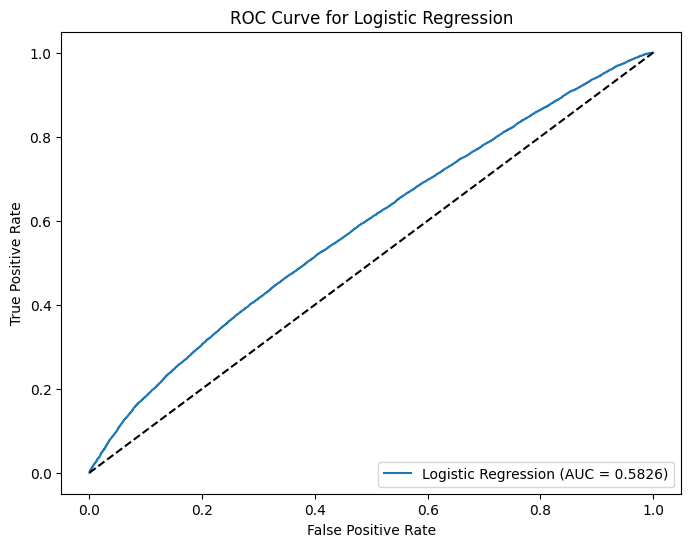

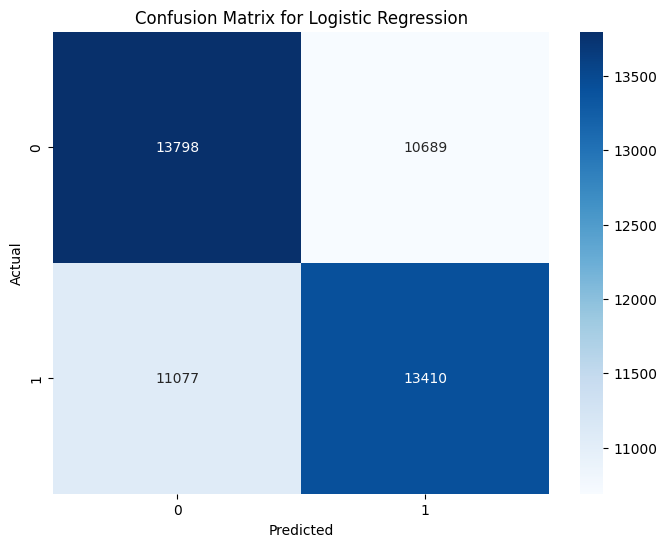


Decision Tree Results:
AUC: 0.8713
Classification Report:
              precision    recall  f1-score       support
0              0.869233  0.874096  0.871658  24487.000000
1              0.873388  0.868502  0.870938  24487.000000
accuracy       0.871299  0.871299  0.871299      0.871299
macro avg      0.871311  0.871299  0.871298  48974.000000
weighted avg   0.871311  0.871299  0.871298  48974.000000
Confusion Matrix:
[[21404  3083]
 [ 3220 21267]]


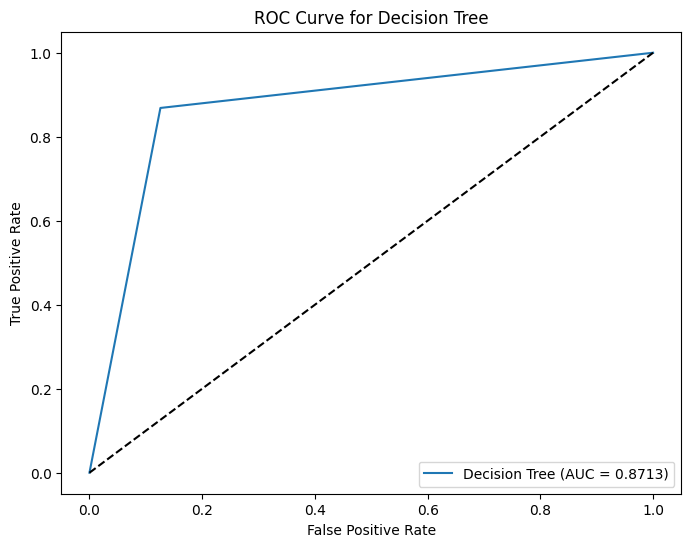

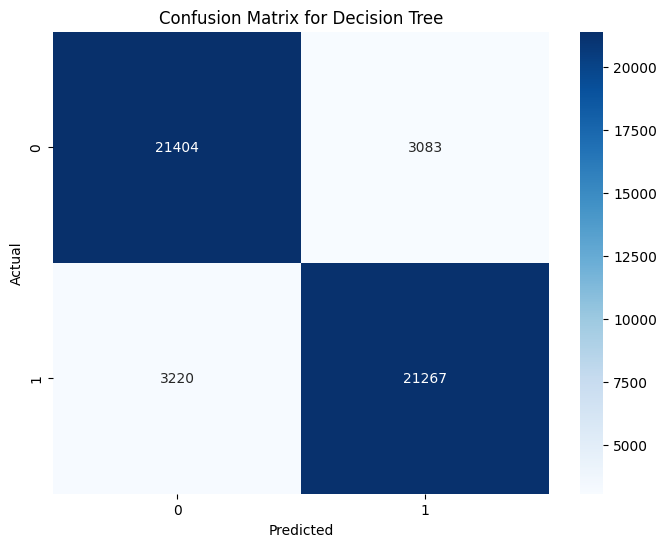

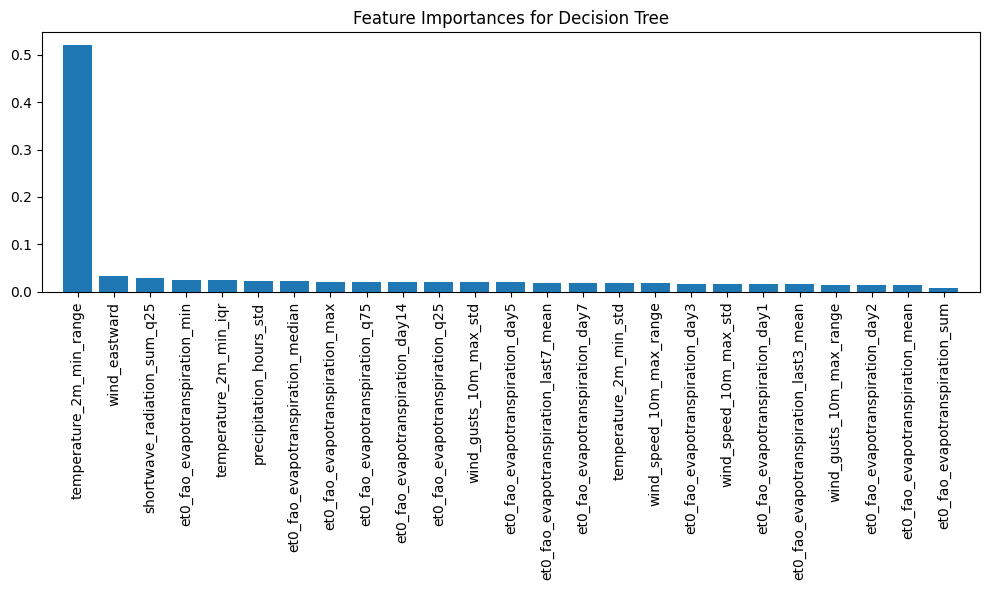

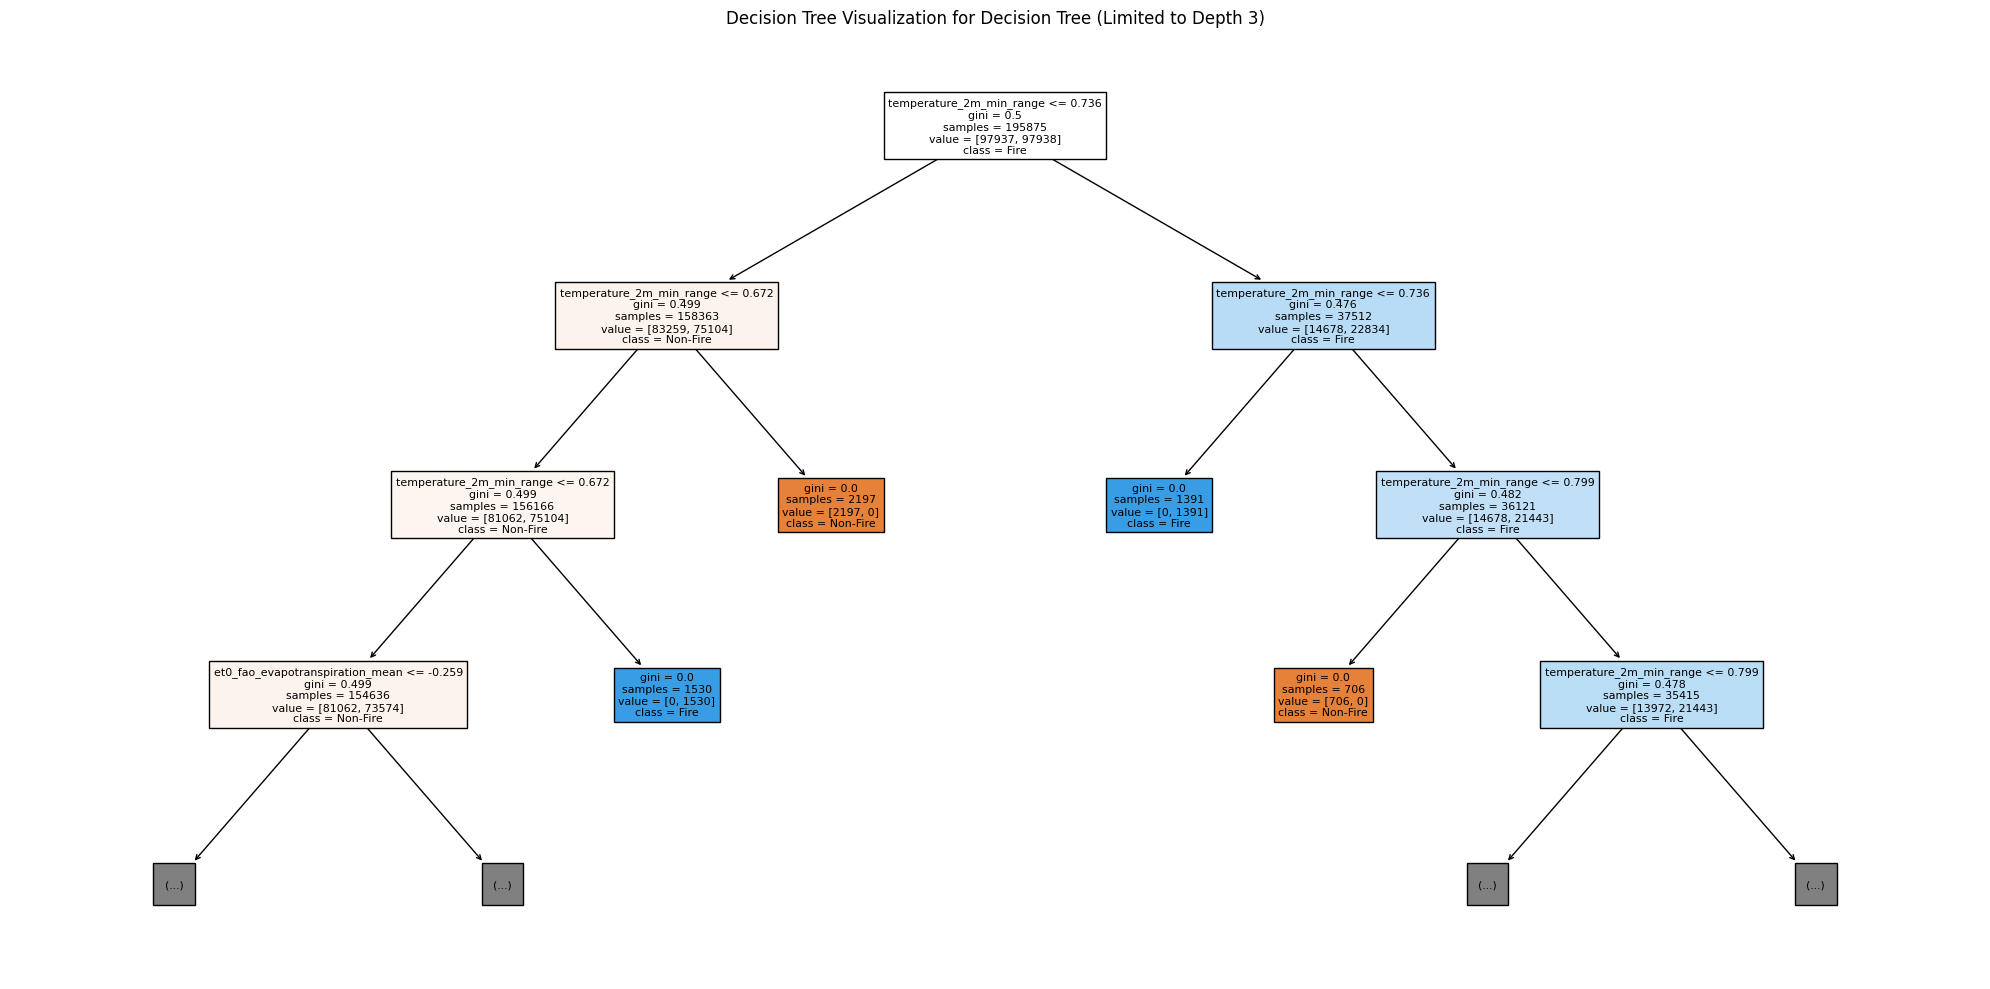


Random Forest Results:
AUC: 0.9130
Classification Report:
              precision    recall  f1-score       support
0              0.834959  0.831992  0.833473  24487.000000
1              0.832587  0.835545  0.834064  24487.000000
accuracy       0.833769  0.833769  0.833769      0.833769
macro avg      0.833773  0.833769  0.833768  48974.000000
weighted avg   0.833773  0.833769  0.833768  48974.000000
Confusion Matrix:
[[20373  4114]
 [ 4027 20460]]


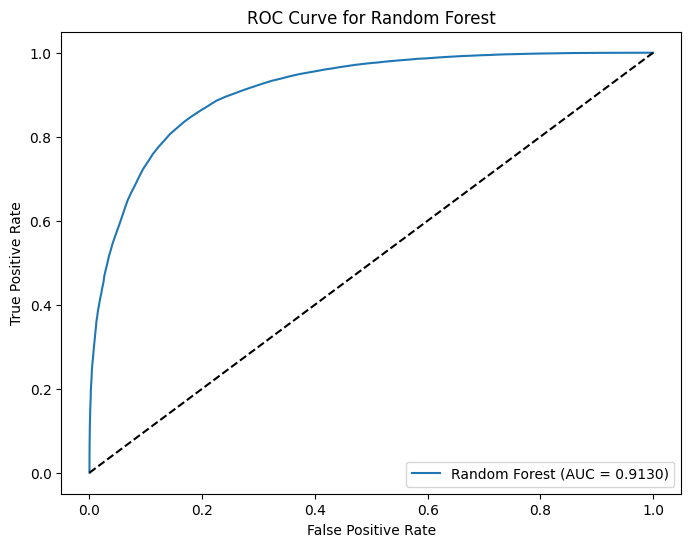

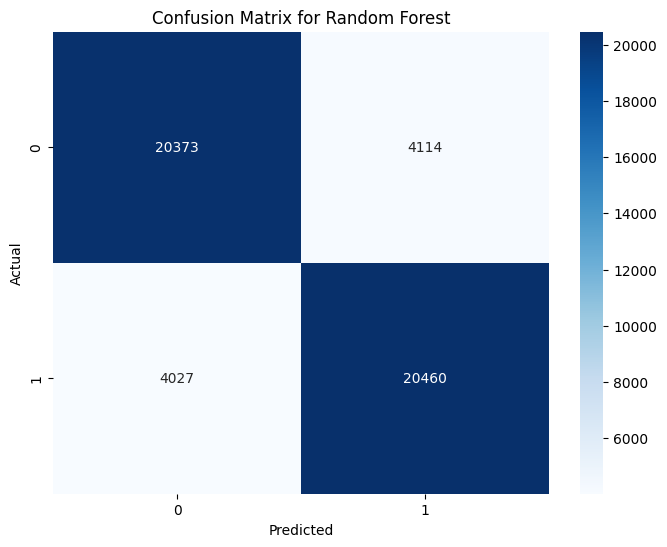

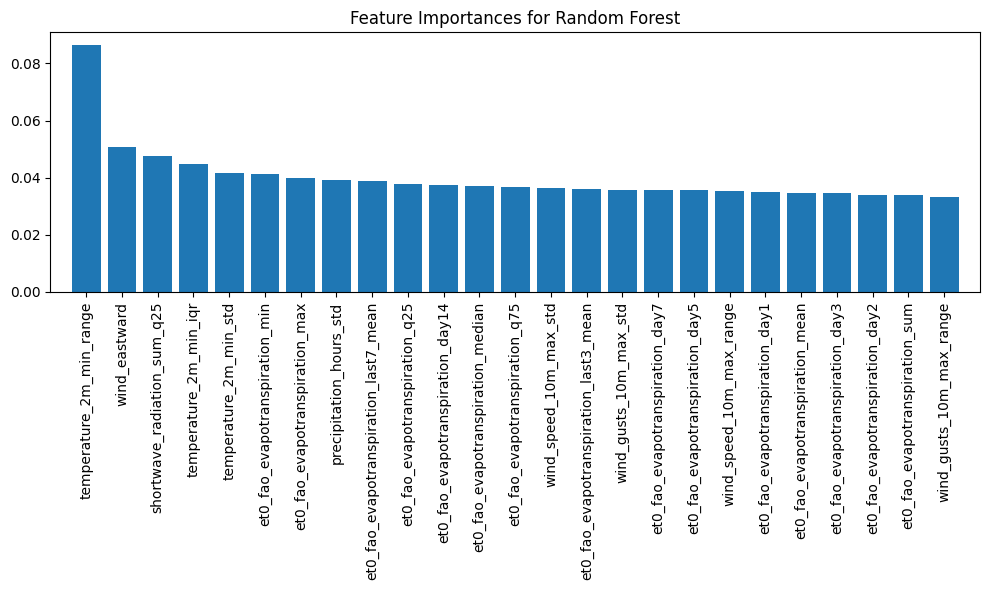

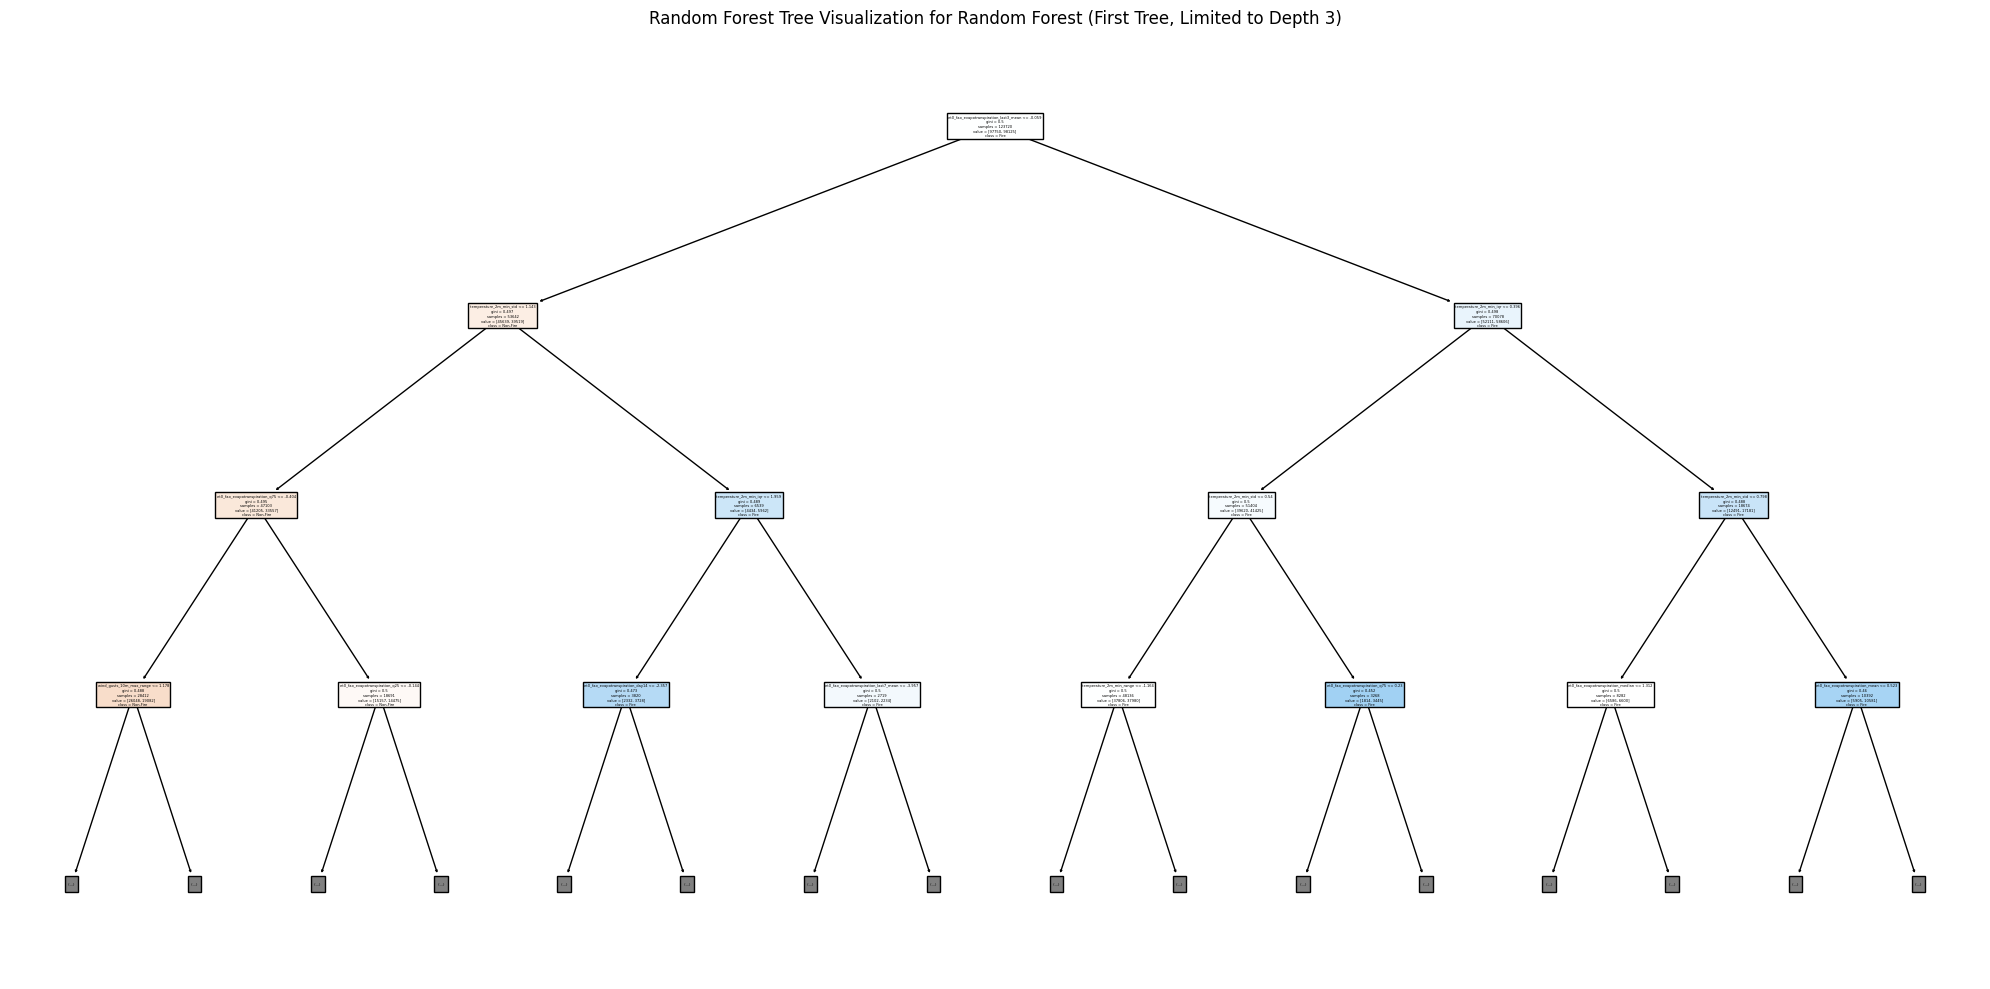


Gradient Boosting Results:
AUC: 0.9388
Classification Report:
              precision    recall  f1-score       support
0              0.859211  0.853106  0.856148  24487.000000
1              0.854142  0.860212  0.857166  24487.000000
accuracy       0.856659  0.856659  0.856659      0.856659
macro avg      0.856677  0.856659  0.856657  48974.000000
weighted avg   0.856677  0.856659  0.856657  48974.000000
Confusion Matrix:
[[20890  3597]
 [ 3423 21064]]


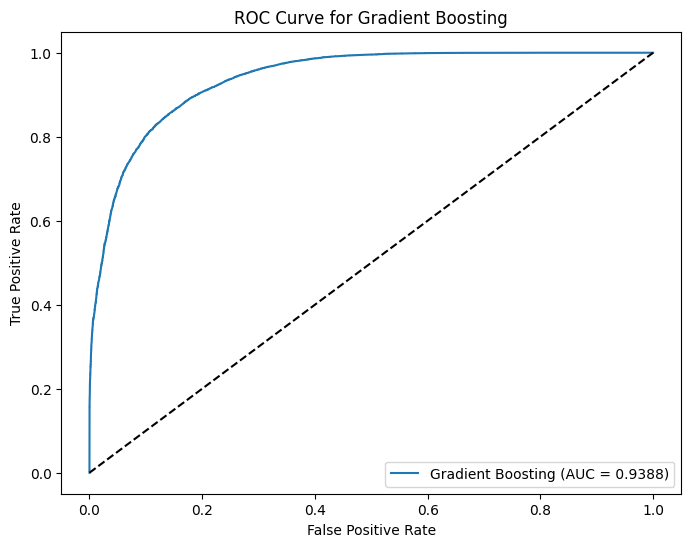

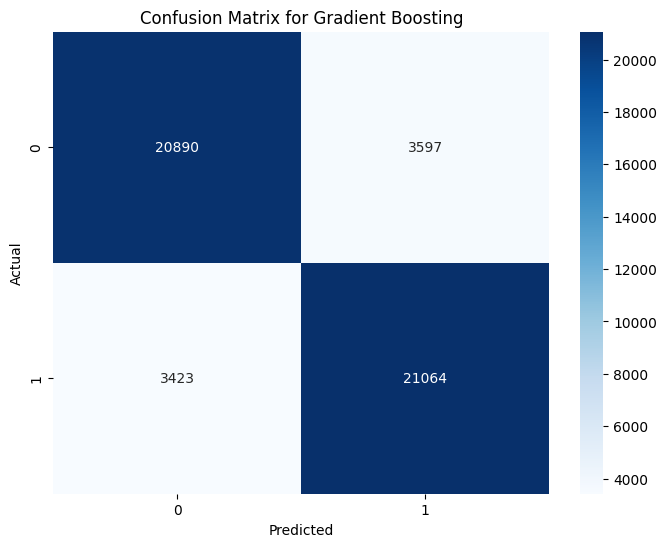

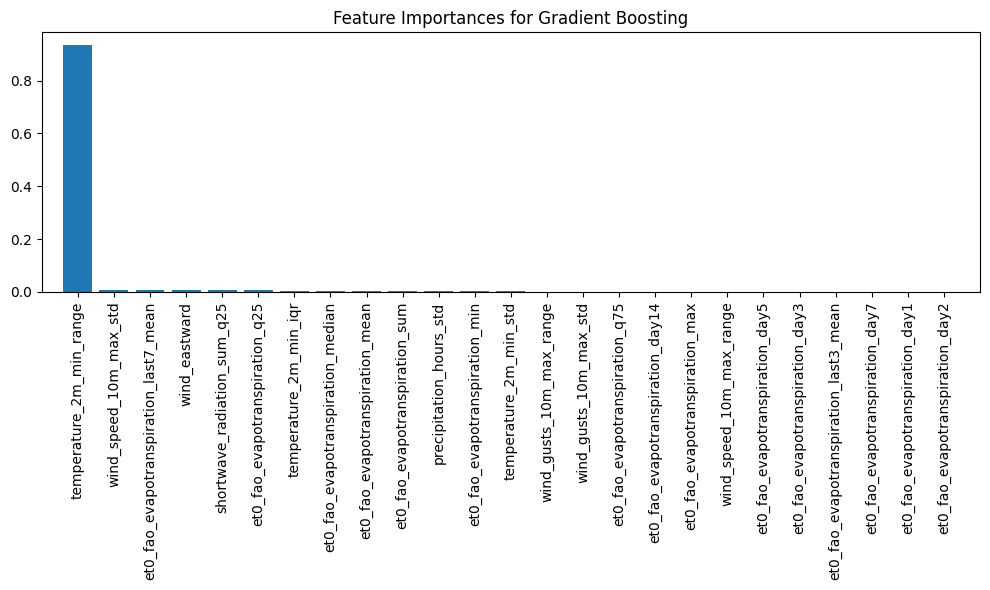


XGBoost Results:
AUC: 0.9888
Classification Report:
              precision    recall  f1-score       support
0              0.959672  0.921264  0.940076  24487.000000
1              0.924294  0.961286  0.942427  24487.000000
accuracy       0.941275  0.941275  0.941275      0.941275
macro avg      0.941983  0.941275  0.941251  48974.000000
weighted avg   0.941983  0.941275  0.941251  48974.000000
Confusion Matrix:
[[22559  1928]
 [  948 23539]]


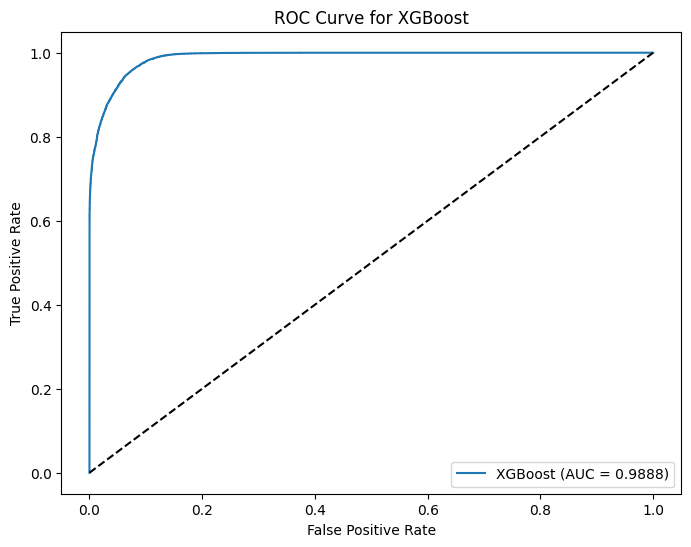

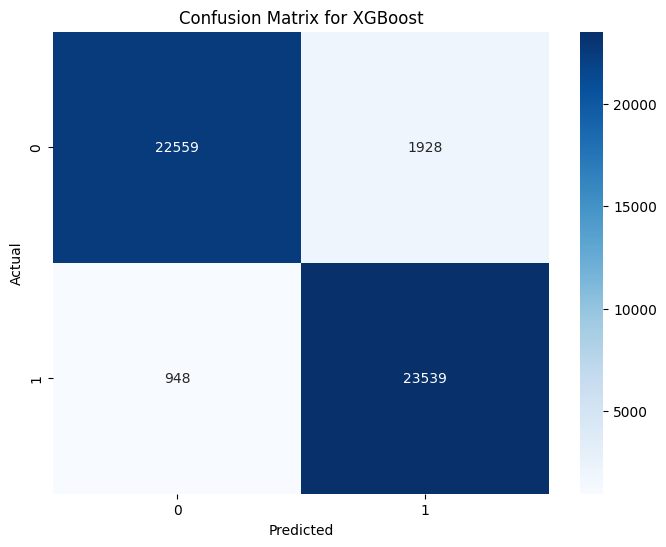

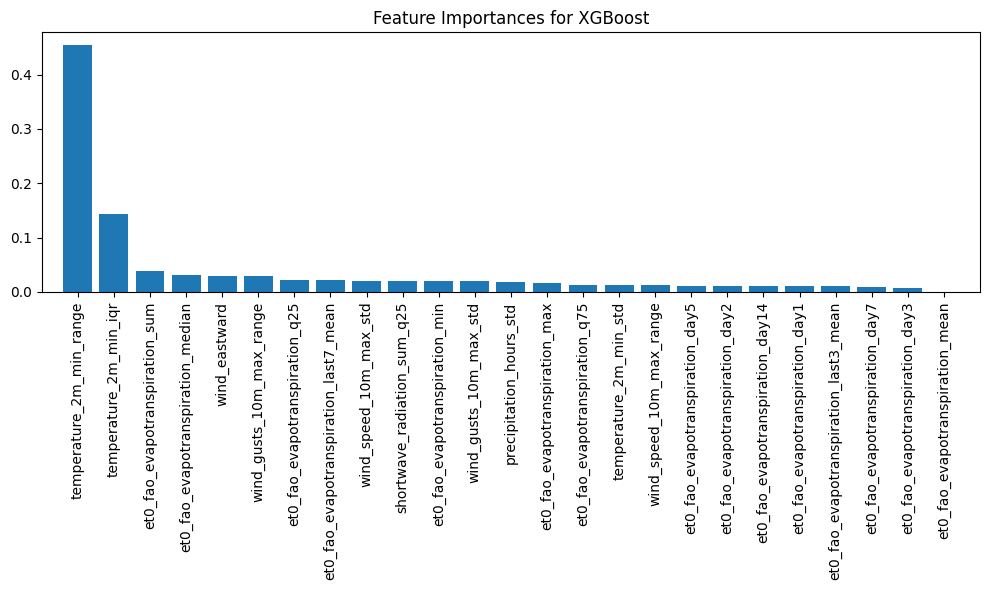

<Figure size 2000x1000 with 0 Axes>


CatBoost Results:
AUC: 0.9992
Classification Report:
              precision    recall  f1-score       support
0              0.992133  0.978601  0.985321  24487.000000
1              0.978889  0.992241  0.985520  24487.000000
accuracy       0.985421  0.985421  0.985421      0.985421
macro avg      0.985511  0.985421  0.985420  48974.000000
weighted avg   0.985511  0.985421  0.985420  48974.000000
Confusion Matrix:
[[23963   524]
 [  190 24297]]


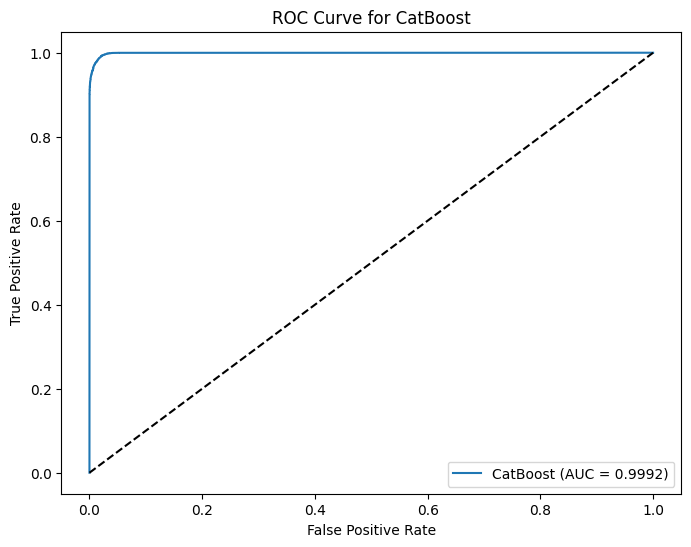

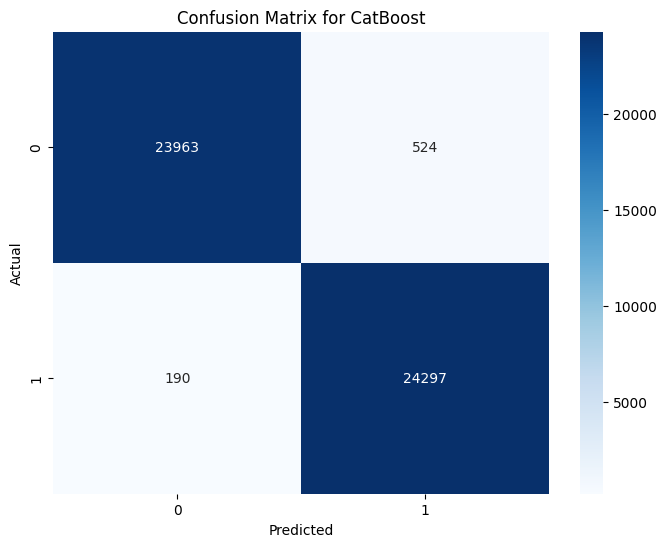

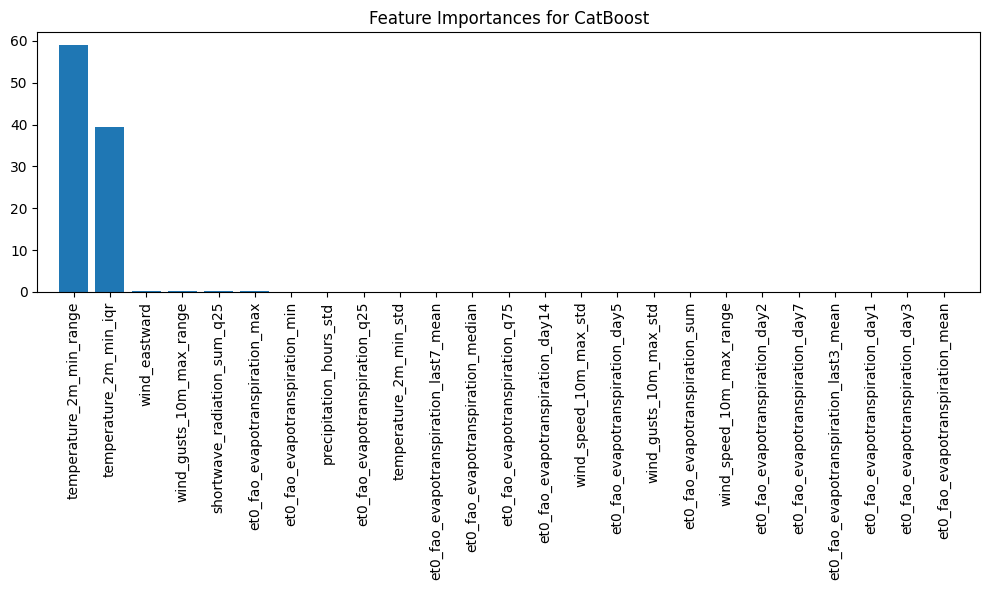

In [16]:
# Initialize models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"Training {name}...")

    # Use scaled data for training and testing
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'classification_report': report,
        'roc_auc': auc,
        'confusion_matrix': cm,
        'model': model
    }
    print(f"{name} AUC: {auc:.4f}")

# Analyze results
for name, result in results.items():
    model = result['model']
    print(f"\n{name} Results:")
    print(f"AUC: {result['roc_auc']:.4f}")
    print("Classification Report:")
    print(pd.DataFrame(result['classification_report']).transpose())
    print("Confusion Matrix:")
    print(result['confusion_matrix'])

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["roc_auc"]:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend(loc='lower right')
    plt.show()

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Feature Importances if available
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 6))
        plt.title(f'Feature Importances for {name}')
        plt.bar(range(X_train_scaled.shape[1]), importances[indices], align='center')
        plt.xticks(range(X_train_scaled.shape[1]), X_train_scaled.columns[indices], rotation=90)
        plt.xlim([-1, X_train_scaled.shape[1]])
        plt.tight_layout()
        plt.show()

    # Visualize Decision Tree for Decision Tree and Random Forest models
    if name in ['Decision Tree', 'Random Forest', 'XGBoost']:
        plt.figure(figsize=(20, 10))
        if name == 'Decision Tree':
            plot_tree(model, filled=True, feature_names=X_train_scaled.columns, class_names=['Non-Fire', 'Fire'], max_depth=3)
            plt.title(f'Decision Tree Visualization for {name} (Limited to Depth 3)')
        elif name == 'Random Forest':
            # Visualize the first tree in the Random Forest
            plot_tree(model.estimators_[0], filled=True, feature_names=X_train_scaled.columns, class_names=['Non-Fire', 'Fire'], max_depth=3)
            plt.title(f'Random Forest Tree Visualization for {name} (First Tree, Limited to Depth 3)')
        plt.tight_layout()
        plt.show()

# Wildfire Spread Rate Prediction - Deep Learning Analysis
Given the poor statistics between the environment variables and the continuous target variables, we first attempt to train a deep neural network that can capture nonlinearities in the data.

In [2]:
import pandas as pd

fire_combined_df_augmented = pd.read_csv('../data/fire_events_with_weather_metrics_augmented.csv')
fire_combined_df_augmented

,id,geometry,ig_date,ig_day,ig_month,ig_year,last_date,event_dur,tot_pix,tot_ar_km2,...,fwi_proxy_day14,fwi_proxy_7d,wind_temp_day1,wind_temp_day3,wind_temp_day5,wind_temp_day7,wind_temp_trend,wind_dir_stability_7d,temp_trend_7d,fwi_high_days_14d
0,16,MULTIPOLYGON (((-10012651.656358264 4811038.34...,2018-10-22,295,10,2018,2018-10-22,1,1,0.214659,...,654.099250,83.798268,1196.926597,1111.094784,887.537728,849.222132,-63.333523,8.278679,-0.091379,0
1,19,MULTIPOLYGON (((-10032574.656358264 4806405.34...,2018-10-20,293,10,2018,2018-10-20,1,1,0.214659,...,92.115894,91.748154,1152.389431,886.013542,938.291498,1064.355642,-10.591171,14.978169,0.146983,1
2,21,MULTIPOLYGON (((-10039523.656358264 4803161.84...,2023-09-16,259,9,2023,2023-09-16,1,1,0.214659,...,476.557164,98.448596,891.415361,1065.444189,874.990143,795.416853,-23.922479,33.305454,0.015948,0
3,25,MULTIPOLYGON (((-10089098.656358264 4795751.15...,2020-09-05,249,9,2020,2020-09-11,7,10,2.146587,...,131.726826,281.160053,738.361532,1127.817676,945.160114,914.714062,17.320001,6.715788,0.080603,0
4,26,MULTIPOLYGON (((-10039060.656358264 4794822.34...,2018-10-20,293,10,2018,2018-10-20,1,1,0.214659,...,90.284144,88.886220,1151.372618,879.218048,930.962086,1069.772274,-9.652850,14.821836,0.137931,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122476,517086,MULTIPOLYGON (((-5559753.156358264 7693770.843...,2019-08-22,234,8,2019,2019-08-22,1,1,0.214659,...,96.125183,97.030232,422.144999,867.562328,307.542730,758.884050,22.509878,168.649499,0.121121,2
122477,517087,MULTIPOLYGON (((-5559753.156358264 7686820.843...,2019-08-16,228,8,2019,2019-08-26,11,7,1.502611,...,1535.784617,184.341902,758.884050,856.688664,891.752222,556.640802,-28.583309,90.940617,0.288793,0
122478,517088,MULTIPOLYGON (((-5559753.156358264 7683114.843...,2019-08-16,228,8,2019,2019-08-16,1,2,0.429317,...,4618.928483,186.878218,768.690862,774.098295,885.639875,559.735392,-25.766242,92.085218,0.278017,0
122479,517089,MULTIPOLYGON (((-5559287.843641736 7687749.156...,2021-08-27,239,8,2021,2021-08-29,3,4,0.858635,...,11269.279032,54.625829,398.688589,488.784470,545.229485,368.902652,-1.645640,127.011847,0.267241,3


In [3]:
numerical_features = fire_combined_df_augmented.columns[35:].tolist()
numerical_features

['temperature_2m_max_mean',
 'temperature_2m_max_median',
 'temperature_2m_max_min',
 'temperature_2m_max_max',
 'temperature_2m_max_std',
 'temperature_2m_max_range',
 'temperature_2m_max_q25',
 'temperature_2m_max_q75',
 'temperature_2m_max_iqr',
 'temperature_2m_max_last3_mean',
 'temperature_2m_max_last7_mean',
 'temperature_2m_min_mean',
 'temperature_2m_min_median',
 'temperature_2m_min_min',
 'temperature_2m_min_max',
 'temperature_2m_min_std',
 'temperature_2m_min_range',
 'temperature_2m_min_q25',
 'temperature_2m_min_q75',
 'temperature_2m_min_iqr',
 'temperature_2m_min_last3_mean',
 'temperature_2m_min_last7_mean',
 'apparent_temperature_max_mean',
 'apparent_temperature_max_median',
 'apparent_temperature_max_min',
 'apparent_temperature_max_max',
 'apparent_temperature_max_std',
 'apparent_temperature_max_range',
 'apparent_temperature_max_q25',
 'apparent_temperature_max_q75',
 'apparent_temperature_max_iqr',
 'apparent_temperature_max_last3_mean',
 'apparent_temperature_

In [4]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

categorical_features = ['eco_name', 'lc_name']

X_full = fire_combined_df_augmented[numerical_features + categorical_features].copy()
y_full = fire_combined_df_augmented['fsr_km2_dy'].copy()
valid_idx = ~y_full.isna() & X_full[numerical_features].notna().all(axis=1)
X_full = X_full.loc[valid_idx]
y_full = y_full.loc[valid_idx]

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

sample_size = min(5000, len(X_train_full))  # Cap for speed
X_train_sample = X_train_full[numerical_features].sample(n=sample_size, random_state=42)
y_train_sample = y_train_full.loc[X_train_sample.index]

mi = mutual_info_regression(X_train_sample, y_train_sample, random_state=42)
mi_series = pd.Series(mi, index=numerical_features).sort_values(ascending=False)
top_k = 60  # Adjust as needed
selected_by_mi = mi_series.head(top_k).index.tolist()

X_top = X_train_sample[selected_by_mi]
corr_matrix = X_top.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
final_selected_features = list(set(selected_by_mi) - set(to_drop))

print(f"\nSelected {len(final_selected_features)} features for DNN:")
print(final_selected_features)


Selected 40 features for DNN:
['sunshine_duration_day3', 'wind_speed_10m_max_trend', 'precipitation_hours_day3', 'wind_speed_10m_max_day3', 'wind_direction_10m_dominant_q75', 'wind_temp_day7', 'wind_direction_10m_dominant_day14', 'temperature_2m_max_last3_mean', 'wind_gusts_10m_max_std', 'wind_direction_10m_dominant_q25', 'et0_fao_evapotranspiration_q25', 'sunshine_duration_last7_mean', 'wind_speed_10m_max_max', 'apparent_temperature_max_day5', 'apparent_temperature_min_max', 'wind_eastward', 'precipitation_hours_last7_mean', 'daylight_duration_last3_mean', 'daylight_duration_trend', 'wind_direction_10m_dominant_max', 'sunshine_duration_last3_mean', 'shortwave_radiation_sum_day3', 'wind_east_velocity', 'apparent_temperature_max_day7', 'apparent_temperature_min_std', 'temperature_2m_max_iqr', 'shortwave_radiation_sum_day5', 'precipitation_hours_day5', 'precipitation_sum_trend', 'precipitation_sum_day7', 'rain_sum_median', 'temperature_2m_max_min', 'snowfall_sum_min', 'precipitation_sum

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

numerical_features = final_selected_features

# Drop rows with missing values
X = fire_combined_df_augmented[numerical_features + categorical_features].copy()
y = fire_combined_df_augmented[target].copy()
valid_idx = ~y.isna() & X.notna().all(axis=1)
X = X.loc[valid_idx]
y = y.loc[valid_idx]

# Split dataset
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Pipeline: one-hot + scaling
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_features)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

# Build deep model
def build_dnn(input_dim):
    model = Sequential([
        Dense(512, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-3), loss='mse')
    return model

# Print R2 on val each epoch
class ValR2Callback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0).flatten()
        r2 = r2_score(self.y_val, y_pred)
        print(f" val_R2 = {r2:.4f}")

# Model and callbacks
model = build_dnn(X_train_proc.shape[1])
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
val_r2_callback = ValR2Callback(X_val_proc, y_val)

# Train
model.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler, val_r2_callback],
    verbose=1
)

# Evaluate
y_pred = model.predict(X_test_proc).flatten()
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nFinal DNN Performance on Test Set:")
print(f"R2     = {r2:.4f}")
print(f"RMSE   = {rmse:.4f}")
print(f"MAE    = {mae:.4f}")

/opt/homebrew/anaconda3/envs/311_env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
2025-05-10 00:09:56.059098: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-05-10 00:09:56.059144: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-10 00:09:56.059156: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-10 00:09:56.059415: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-10 00:09:56.059640: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/ta

Epoch 1/100


2025-05-10 00:09:57.040794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1214/1214 [==============================] - 21s 16ms/step - loss: 3.1205 - val_loss: 3.8887 - lr: 0.0010
Epoch 2/100
1214/1214 [==============================] - 19s 16ms/step - loss: 3.1428 - val_loss: 3.9858 - lr: 0.0010
Epoch 3/100
 935/1214 [======================>.......] - ETA: 3s - loss: 3.7805

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
import scipy.stats as stats

categorical_features = ['eco_name', 'lc_name']
target = 'fsr_km2_dy'

# Subset and clean
X = fire_combined_df_augmented[numerical_features + categorical_features].copy()
y = fire_combined_df_augmented[target].copy()
valid_idx = ~y.isna() & X.notna().all(axis=1)
X = X.loc[valid_idx]
y = y.loc[valid_idx]

# Split without log transform
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

print(len(X_train_full))
print(len(X_train))
print(len(X_val))
print(len(X_test))

# Preprocess
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_features)
])
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

# More complex DNN definition
def build_dnn(input_dim):
    model = Sequential([
        Dense(512, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), input_dim=input_dim),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.3),

        Dense(256, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.1),

        Dense(32),
        LeakyReLU(alpha=0.1),

        Dense(1)
    ])
    # Using Huber loss instead of MSE to be more robust to outliers
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
                  loss=tf.keras.losses.Huber(delta=1.0))
    return model

# R² Callback
class ValR2Callback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0).flatten()
        r2 = r2_score(self.y_val, y_pred)
        print(f" val_R² = {r2:.4f}")

model = build_dnn(X_train_proc.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_sched = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)
val_r2_cb = ValR2Callback(X_val_proc, y_val)

history = model.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=200,
    batch_size=256, 
    callbacks=[early_stop, lr_sched, val_r2_cb],
    verbose=1
)

# Evaluate
y_pred = model.predict(X_test_proc).flatten()
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nFinal DNN Performance on Test Set:")
print(f"R²     = {r2:.4f}")
print(f"RMSE   = {rmse:.4f}")
print(f"MAE    = {mae:.4f}")

r2, rmse, mae

96572
77257
19315
24144


/opt/homebrew/anaconda3/envs/311_env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/200
302/302 [==============================] - 16s 47ms/step - loss: 0.5372 - val_loss: 0.3602 - lr: 1.0000e-04
Epoch 2/200
242/302 [=======================>......] - ETA: 2s - loss: 0.3986

# ML Analysis for Multivariate Regression on fsr_km2_dy and tot_ar_km2

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import joblib
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

def train_evaluate_models(df, selected_features, categorical_features, target, test_size=0.2, random_state=42):
    """
    Train and evaluate multiple regression models on the given dataset.
    """
    # Subset and clean
    X = df[selected_features + categorical_features].copy()
    y = df[target].copy()
    valid_idx = ~y.isna() & X.notna().all(axis=1)
    X = X.loc[valid_idx]
    y = y.loc[valid_idx]

    # Apply label encoding to categorical features
    label_encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    models = {
        'Linear': Pipeline([
            ('scaler', RobustScaler()), 
            ('model', Ridge(alpha=10.0, solver='lsqr', random_state=random_state)) 
        ]),

        'RandomForest': Pipeline([
            ('scaler', MinMaxScaler()),
            ('model', RandomForestRegressor(
                n_estimators=200, 
                max_depth=6,     
                min_samples_leaf=10,
                min_samples_split=10,
                max_features=0.5,  
                n_jobs=-1,
                random_state=random_state
            ))
        ]),

        'GradientBoosting': Pipeline([
            ('scaler', MinMaxScaler()),
            ('model', GradientBoostingRegressor(
                n_estimators=150,
                learning_rate=0.03, 
                max_depth=3,        
                subsample=0.7,      
                max_features=0.6,
                min_samples_leaf=10,
                min_samples_split=10,
                random_state=random_state
            ))
        ]),
        
        'XGBoost': Pipeline([
            ('scaler', MinMaxScaler()),
            ('model', xgb.XGBRegressor(
                n_estimators=150,
                learning_rate=0.03,
                max_depth=4,
                subsample=0.7,
                colsample_bytree=0.6,
                reg_alpha=0.5,
                reg_lambda=2.0,
                min_child_weight=5,
                gamma=0.1,
                random_state=random_state,
                n_jobs=-1
            ))
        ]),
        
        'LightGBM': Pipeline([
            ('scaler', MinMaxScaler()),
            ('model', lgb.LGBMRegressor(
                n_estimators=150,
                learning_rate=0.03,
                max_depth=4,
                num_leaves=20,
                subsample=0.7,
                colsample_bytree=0.6,
                reg_alpha=0.5,
                reg_lambda=2.0,
                min_child_samples=20,
                random_state=random_state,
                n_jobs=-1
            ))
        ]),
        
        'CatBoost': Pipeline([
            ('scaler', MinMaxScaler()),
            ('model', CatBoostRegressor(
                iterations=150,
                learning_rate=0.03,
                depth=4,
                l2_leaf_reg=5,
                random_strength=0.2,
                bagging_temperature=0.8,
                min_data_in_leaf=10,
                random_seed=random_state,
                verbose=0
            ))
        ]),

        'Baseline': Pipeline([
            ('scaler', MinMaxScaler()),
            ('model', Ridge(alpha=1.0))
        ])
    }

    # Train and evaluate models
    results = {
        'model_name': [],
        'train_r2': [],
        'test_r2': [],
        'rmse': [],
        'mae': [],
        'overfitting': [],
        'model': []
    }

    print("\nTraining models...")
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)

        # Evaluate on training data
        y_train_pred = model.predict(X_train)
        train_r2 = r2_score(y_train, y_train_pred)

        # Evaluate on test data
        y_test_pred = model.predict(X_test)
        test_r2 = r2_score(y_test, y_test_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        mae = mean_absolute_error(y_test, y_test_pred)
        
        # Calculate overfitting metric
        overfitting = train_r2 - test_r2

        # Store results
        results['model_name'].append(name)
        results['train_r2'].append(train_r2)
        results['test_r2'].append(test_r2)
        results['rmse'].append(rmse)
        results['mae'].append(mae)
        results['overfitting'].append(overfitting)
        results['model'].append(model)

        print(f"{name}: Train R2 = {train_r2:.4f}, Test R2 = {test_r2:.4f}, RMSE = {rmse:.4f}, Overfitting = {overfitting:.4f}")

    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('test_r2', ascending=False)

    print("\nModel Results (sorted by test R2):")
    print(results_df)

    # Get best model
    best_model_name = results_df.iloc[0]['model_name']
    best_model = models[best_model_name]
    best_r2 = results_df.iloc[0]['test_r2']

    print(f"\nBest model: {best_model_name} (Test R2 = {best_r2:.4f})")
    return results_df, best_model, best_model_name

In [ ]:
categorical_features = ['eco_name', 'lc_name']
target = 'fsr_km2_dy'

results_df, best_model, best_model_name = train_evaluate_models(
    df=fire_combined_df_augmented,
    selected_features=final_selected_features,
    categorical_features=categorical_features,
    target=target
)


Training models...
Linear: Train R2 = 0.0039, Test R2 = 0.0052, RMSE = 1.6731, Overfitting = -0.0013
RandomForest: Train R2 = 0.0894, Test R2 = 0.0305, RMSE = 1.6517, Overfitting = 0.0589
GradientBoosting: Train R2 = 0.0873, Test R2 = 0.0305, RMSE = 1.6518, Overfitting = 0.0568
XGBoost: Train R2 = 0.1761, Test R2 = 0.0298, RMSE = 1.6524, Overfitting = 0.1464
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9411
[LightGBM] [Info] Number of data points in the train set: 97064, number of used features: 41
[LightGBM] [Info] Start training from score 0.444684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [12]:
results_df_tot_ar_km2, best_model_tot_ar_km2, best_model_name_tot_ar_km2 = train_evaluate_models(
    df=fire_combined_df_augmented,
    selected_features=final_selected_features,
    categorical_features=categorical_features,
    target='tot_ar_km2'
)


Training models...
Linear: Train R2 = 0.0030, Test R2 = 0.0018, RMSE = 41.4108, Overfitting = 0.0013
RandomForest: Train R2 = 0.0689, Test R2 = 0.0061, RMSE = 41.3203, Overfitting = 0.0627
GradientBoosting: Train R2 = 0.0484, Test R2 = 0.0056, RMSE = 41.3300, Overfitting = 0.0427
XGBoost: Train R2 = 0.1082, Test R2 = 0.0077, RMSE = 41.2876, Overfitting = 0.1005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9411
[LightGBM] [Info] Number of data points in the train set: 97064, number of used features: 41
[LightGBM] [Info] Start training from score 2.521888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [16]:
results_df_tot_ar_km2, best_model_tot_ar_km2, best_model_name_tot_ar_km2 = train_evaluate_models(
    df=fire_combined_df_augmented,
    selected_features=final_selected_features,
    categorical_features=categorical_features,
    target='mx_grw_km2'
)


Training models...
Linear: Train R2 = 0.0018, Test R2 = 0.0029, RMSE = 9.2024, Overfitting = -0.0011
RandomForest: Train R2 = 0.1017, Test R2 = 0.0174, RMSE = 9.1354, Overfitting = 0.0843
GradientBoosting: Train R2 = 0.0963, Test R2 = 0.0122, RMSE = 9.1593, Overfitting = 0.0840
XGBoost: Train R2 = 0.2502, Test R2 = 0.0162, RMSE = 9.1409, Overfitting = 0.2340
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9411
[LightGBM] [Info] Number of data points in the train set: 97064, number of used features: 41
[LightGBM] [Info] Start training from score 1.151325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

## Multivariate Classification into Daily Fire Spread Rate Severity

In [20]:
from catboost import CatBoostClassifier

def train_evaluate_classification_models(df, selected_features, categorical_features, target='fsr_km2_dy', test_size=0.2, random_state=42):
    """
    Train and evaluate multiple classification models after segmenting fire spread rate into severity classes.
    """
    # Subset and clean
    X = df[selected_features + categorical_features].copy()
    y_raw = df[target].copy()
    valid_idx = ~y_raw.isna() & X.notna().all(axis=1)
    X = X.loc[valid_idx]
    y_raw = y_raw.loc[valid_idx]
    
    # Convert to categorical classes
    def categorize_fsr(x):
        if x < 0.3:
            return 0  # Low
        elif x < 1.0:
            return 1  # Moderate
        else:
            return 2  # High
    
    def categorize_tot_arr_km2(x):
        if x < 0.5:  # Roughly median
            return 0  # Low
        elif x < 2.0:  # Between median and 75th percentile+
            return 1  # Moderate
        else:  # Above 75th percentile
            return 2  # High
    
    if target == 'fsr_km2_dy':
        y = y_raw.apply(categorize_fsr)
    elif target == 'tot_ar_km2':
        y = y_raw.apply(categorize_tot_arr_km2)
    
    # Check class distribution
    print("Class distribution:")
    print(y.value_counts(normalize=True).sort_index())

    # Apply label encoding to categorical features
    label_encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    
    models = {
        'LogisticRegression': Pipeline([
            ('scaler', RobustScaler()), 
            ('model', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=random_state))
        ]),

        'RandomForest': Pipeline([
            ('scaler', MinMaxScaler()),
            ('model', RandomForestClassifier(
                n_estimators=200, 
                max_depth=6,
                class_weight='balanced',
                n_jobs=-1,
                random_state=random_state
            ))
        ]),
        
        'XGBoost': Pipeline([
            ('scaler', MinMaxScaler()),
            ('model', xgb.XGBClassifier(
                n_estimators=150,
                learning_rate=0.03,
                max_depth=4,
                subsample=0.7,
                colsample_bytree=0.6,
                use_label_encoder=False,
                eval_metric='mlogloss',
                random_state=random_state,
                n_jobs=-1
            ))
        ]),
        
        'LightGBM': Pipeline([
            ('scaler', MinMaxScaler()),
            ('model', lgb.LGBMClassifier(
                n_estimators=150,
                learning_rate=0.03,
                max_depth=4,
                class_weight='balanced',
                random_state=random_state,
                n_jobs=-1
            ))
        ]),
        
        'CatBoost': Pipeline([
            ('scaler', MinMaxScaler()),
            ('model', CatBoostClassifier(
                iterations=150,
                learning_rate=0.03,
                depth=4,
                verbose=0,
                random_seed=random_state
            ))
        ])
    }

    # Train and evaluate models
    results = {
        'model_name': [],
        'accuracy': [],
        'precision_weighted': [],
        'recall_weighted': [],
        'f1_weighted': [],
        'model': []
    }

    print("\nTraining classification models...")
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        
        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Store results
        results['model_name'].append(name)
        results['accuracy'].append(accuracy)
        results['precision_weighted'].append(precision)
        results['recall_weighted'].append(recall)
        results['f1_weighted'].append(f1)
        results['model'].append(model)

        print(f"{name}: Accuracy = {accuracy:.4f}, F1 = {f1:.4f}")
        
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('f1_weighted', ascending=False)

    print("\nModel Results (sorted by F1 score):")
    print(results_df[['model_name', 'accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']])

    # Get best model
    best_model_name = results_df.iloc[0]['model_name']
    best_model = models[best_model_name]
    best_f1 = results_df.iloc[0]['f1_weighted']

    print(f"\nBest model: {best_model_name} (F1 = {best_f1:.4f})")
    
    # Display classification report for best model
    best_pred = best_model.predict(X_test)
    print("\nClassification Report for Best Model:")
    print(classification_report(y_test, best_pred, target_names=['Low', 'Moderate', 'High']))
    
    return results_df, best_model, best_model_name

In [21]:
print("Training models for fire spread rate (fsr_km2_dy)...")
fsr_results, fsr_best_model, fsr_best_model_name = train_evaluate_classification_models(
    df=fire_combined_df_augmented, 
    selected_features=final_selected_features, 
    categorical_features=categorical_features,
    target='fsr_km2_dy', 
    test_size=0.2, 
    random_state=42
)

print("\n" + "="*80 + "\n")

print("Training models for total area (tot_ar_km2)...")
area_results, area_best_model, area_best_model_name = train_evaluate_classification_models(
    df=fire_combined_df_augmented, 
    selected_features=final_selected_features, 
    categorical_features=categorical_features,
    target='tot_ar_km2', 
    test_size=0.2, 
    random_state=42
)

# Compare the best models for both targets
print("\nComparison of Best Models:")
print(f"Fire Spread Rate: {fsr_best_model_name} (F1 = {fsr_results.iloc[0]['f1_weighted']:.4f})")
print(f"Total Area: {area_best_model_name} (F1 = {area_results.iloc[0]['f1_weighted']:.4f})")

Training models for fire spread rate (fsr_km2_dy)...
Class distribution:
fsr_km2_dy
0    0.686211
1    0.254793
2    0.058996
Name: proportion, dtype: float64


NameError: name 'CatBoostClassifier' is not defined